In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, Subset
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from UtilityGraph import *
from Defence import *
from Corruption import *
from UtilityMLP import *
import random
import copy
import itertools
from Test import *
from ipywidgets import interact, IntSlider
import copy

# Device configuration (use GPU if available)
device = torch.device('cuda')
# %matplotlib notebook
%matplotlib widget

In [ ]:
Seed = 42  # for reproducibility
random.seed(Seed)
np.random.seed(Seed) 
torch.manual_seed(Seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(Seed)
    torch.cuda.manual_seed_all(Seed)

# Graph
required_probability=0.9999
Amount_Clients = 20
num_nodes, G,A,pos,r_c=build_random_graph(Amount_Clients,required_probability,fix_num_nodes=True)


In [ ]:
print("num_nodes:",num_nodes)

# Hyperparameters
input_size = 28 * 28        # MNIST images are 28x28 pixels
hidden_size = 128           # Number of neurons in the hidden layer
num_classes = 10            # Number of output classes (digits 0-9)
num_epochs = 5             # Number of local training epochs per aggregation 
batch_size = 64             # Batch size for training
learning_rate = 0.01        # Learning rate for the optimizer
num_clients = num_nodes     # Number of clients 
num_rounds = 1              # Number of aggregation rounds
threshold = 0.02            # Loss threshold for stopping criteria

percentageCorrupt = 0/num_nodes        #Percentage of corrupt clients
corrupt = True              #If True, corrupt clients are included
CorruptClients = CorruptGeneration(percentageCorrupt, corrupt, num_clients) #Selection of Corrupt Clients

lying_nodes = 0
lying_nodes = np.where(CorruptClients == 1)[0]
true_nodes = [i for i in range(num_nodes) if i not in lying_nodes]

all_nodes = np.union1d(lying_nodes, true_nodes)
print("Corrupt Clients:", lying_nodes)
tolerance=-1                #PDMM tolerance
c=0.5                       #PDMM c
max_iters=1000             #PDMM max iterations
when = 0
CorruptValue = -100000000000000000

rejection_threshold = 20**20
K_decision = 5
averaging = 1
noise_levels = [0]
# noise_levels = [0, 1] 
# noise_levels = [0, 10**-2,1,10**2,10**4] 
# noise_levels = [0, 10**-6,10**-4,10**-2,1] 
# noise_levels = [10**4, 10**8, 10**16] 

var = 10                  # Standard deviation for Gaussian noise
mean = 10**8                   # Mean for Gaussian noise
Target = np.random.randint(1, num_clients) # Target client for copycat attack
scale = 0
typeAttack = 6              # 0: Label Flipping attack, 1: Gaussian noise, 2: Copycat attack, 3: Gaussian addative noise attack, 4: LIE attack, 5 Sign flip attack, 6: No attack
PrivacyMethod = 0       # 0: No privacy, 1: DP, 2: SMPC, 3: Subspace
# PrimModulo = [2**32 - 5, 2**32 - 5, 2**61 - 1] # Prime number for SMPC should be above sum of all client local model values
PrimModulo = [0]

neighbors_dict = {}
for ln in lying_nodes:
    neighbors_dict[ln] = list(G.neighbors(ln))
save = False
print("Neighbors of lying nodes:", neighbors_dict)

In [ ]:
plt.figure(figsize=(8,6))
color_map = []
for node in range(num_nodes):
    if node in lying_nodes:
        color_map.append('red')   # corrupt
    else:
        color_map.append('blue')  # honest

nx.draw(G, pos, with_labels=True, node_color=color_map)
plt.title("Graph with Lying (Red) and Honest (Blue) Nodes")
plt.show()

# Create a subgraph containing only honest nodes
remaining_nodes = [n for n in G.nodes() if n not in lying_nodes]
G_sub = G.subgraph(remaining_nodes)

still_connected = nx.is_connected(G_sub)
print("Are the honest‐only nodes still forming a connected subgraph?", still_connected)

# Check that every honest node has a majority of honest neighbors
all_honest = [n for n in G.nodes() if n not in lying_nodes]
all_good = True  # Flag to track if all honest nodes pass the check

for node in all_honest:
    neighbors = list(G.neighbors(node))
    total_neighbors = len(neighbors)
    # Count honest neighbors (neighbors that are not in lying_nodes)
    honest_neighbors = sum(1 for neighbor in neighbors if neighbor not in lying_nodes)
    
    # Only check nodes that have at least one neighbor; if a node is isolated, it might need special handling
    if total_neighbors > 0:
        if honest_neighbors <= total_neighbors / 2:
            print(f"Honest node {node} does not have majority honest neighbors: {honest_neighbors} honest out of {total_neighbors} neighbors")
            all_good = False
            
print("Are all honest nodes connected to a majority of honest neighbors?", all_good)

In [ ]:
def plot_combined_metrics(results, round, typeAttack, PrivacyMethod,save):
    # Define markers for different sigma values
    markers = ['o', 's', 'd', '^', 'v', '<', '>', 'p', '*', 'h', '+', 'x']
    
    # Group results by noise level
    noise_groups = {}
    for res in results:
        if PrivacyMethod == 2:
            key = 0
        else:
            # use .get so missing keys map to 0
            key = res.get('noise_STD', 0) or 0
        noise_groups.setdefault(key, []).append(res)

    # Create plots
    fig, axs = plt.subplots(3, 1, figsize=(10, 8))

    # Convert noise levels to sorted list for consistent markers
    sorted_noises = sorted(noise_groups.keys())

    # Define base sparsity (every N points)
    base_markevery = 17  
    
    # Plot FAR
    for idx, noise in enumerate(sorted_noises):
        group = noise_groups[noise]
        far_matrix = np.array([res['FAR'] for res in group])
        avg_far = np.mean(far_matrix, axis=0)
        marker = markers[idx % len(markers)]  # Cycle through markers
        offset = (idx*50) % base_markevery  # Offset to stagger marker placement
        markevery = (offset, base_markevery)  # Staggered marker appearance
        if PrivacyMethod != 2:
            if noise != 0:
                axs[0].plot(avg_far, marker=marker, markevery=markevery, label=f'$\\sigma^2 = 10^{{{int(np.log10(noise))}}}$', markersize=6)
            else:
                axs[0].plot(avg_far, marker=marker, markevery=markevery, label='$\\sigma^2 = 0$', markersize=6)
        if PrivacyMethod == 2:
            axs[0].plot(avg_far, marker=marker, markevery=markevery, markersize=6)
    axs[0].set_title(f'False Alarm Rate (Round {round})')
    axs[0].set_ylabel('FAR')
    axs[0].grid(True)
    
    # Plot MDR
    for idx, noise in enumerate(sorted_noises):
        group = noise_groups[noise]
        mdr_matrix = np.array([res['MDR'] for res in group])
        avg_mdr = np.mean(mdr_matrix, axis=0)
        marker = markers[idx % len(markers)]
        offset = (idx*50) % base_markevery
        markevery = (offset, base_markevery)
        if PrivacyMethod != 2:
            if noise != 0:
                axs[1].plot(avg_mdr, marker=marker, markevery=markevery, label=f'$\\sigma^2 = 10^{{{int(np.log10(noise))}}}$', markersize=6)
            else:
                axs[1].plot(avg_mdr, marker=marker, markevery=markevery, label='$\\sigma^2 = 0$', markersize=6)
        if PrivacyMethod == 2:
                axs[1].plot(avg_mdr, marker=marker, markevery=markevery , markersize=6)
    axs[1].set_title(f'Missed Detection Rate (Round {round})')
    axs[1].set_ylabel('MDR')
    axs[1].grid(True)

    # Plot Error
    for idx, noise in enumerate(sorted_noises):
        group = noise_groups[noise]
        err_matrix = np.array([res['Error'] for res in group])
        avg_err = np.mean(err_matrix, axis=0)
        marker = markers[idx % len(markers)]
        offset = (idx*50) % base_markevery
        markevery = (offset, base_markevery)
        if PrivacyMethod != 2:
            if noise != 0:
                axs[2].plot(avg_err, marker=marker, markevery=markevery, label=f'$\\sigma^2 = 10^{{{int(np.log10(noise))}}}$', markersize=6)
            else:
                axs[2].plot(avg_err, marker=marker, markevery=markevery, label='$\\sigma^2 = 0$', markersize=6)
        if PrivacyMethod == 2:
            axs[2].plot(avg_err, marker=marker, markevery=markevery, markersize=6)
    axs[2].set_title(f'Consensus Error (Round {round})')
    axs[2].set_ylabel('Error')
    axs[2].set_xlabel('Iteration')
    axs[2].set_yscale('log')
    axs[2].grid(True)
    if PrivacyMethod != 2:
        axs[2].legend()  # Add legend for the third plot
    plt.tight_layout()
    if save == True:
        filename = f"combined_metrics_typeAttack{typeAttack}_PrivacyMethod{PrivacyMethod}_Round{round}.png"
        plt.savefig(filename, dpi=300)
    plt.show()


In [ ]:
# Define the -layer MLP model
class Current(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Current, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # First fully connected layer
        self.relu = nn.ReLU()                          # ReLU activation function
        self.fc2 = nn.Linear(hidden_size, num_classes) # Second fully connected layer

    def forward(self, x):
        x = x.view(-1, input_size)  # Flatten the input tensor
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out


In [ ]:
# class Current(nn.Module):
#     def __init__(self, input_size, hidden_size, num_classes):
#         super(Current, self).__init__()
        
#         self.layers = nn.Sequential(
#             nn.Linear(input_size, hidden_size),  # Layer 1
#             nn.ReLU(),
#             nn.Linear(hidden_size, hidden_size), # Layer 2
#             nn.ReLU(),
#             nn.Linear(hidden_size, hidden_size), # Layer 3
#             nn.ReLU(),
#             nn.Linear(hidden_size, hidden_size), # Layer 4
#             nn.ReLU(),
#             nn.Linear(hidden_size, hidden_size), # Layer 5
#             nn.ReLU(),
#             nn.Linear(hidden_size, hidden_size), # Layer 6
#             nn.ReLU(),
#             nn.Linear(hidden_size, num_classes)  # Output Layer (Layer 7)
#         )

#     def forward(self, x):
#         x = x.view(x.size(0), -1)  # Flatten the input
#         return self.layers(x)


In [ ]:
# class Current(nn.Module):
#     def __init__(self, input_size, hidden_size, num_classes):
#         super(Current, self).__init__()
#         # First convolution: input 1 channel, output 32 channels, 3x3 kernel, stride 1
#         self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1)
#         # Second convolution: input 32 channels, output 64 channels, 3x3 kernel, stride 1
#         self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1)
#         # Max pooling with a 2x2 kernel (default stride is kernel_size)
#         self.pool = nn.MaxPool2d(kernel_size=2)
#         # Dropout before flattening with p=0.25
#         self.dropout1 = nn.Dropout(p=0.25)
#         # Fully connected layer: input dimension is 64 channels * 12 * 12 = 9216, output is 128
#         self.fc1 = nn.Linear(in_features=64 * 12 * 12, out_features=128)
#         # Dropout after first FC with p=0.5
#         self.dropout2 = nn.Dropout(p=0.5)
#         # Final fully connected layer: 128 -> 10 classes
#         self.fc2 = nn.Linear(in_features=128, out_features=10)

#     def forward(self, x):
#         # x is expected to be of shape (batch_size, 1, 28, 28)
#         # First conv + ReLU: output shape (batch_size, 32, 26, 26)
#         x = F.relu(self.conv1(x))
#         # Second conv + ReLU: output shape (batch_size, 64, 24, 24)
#         x = F.relu(self.conv2(x))
#         # Max pooling: output shape (batch_size, 64, 12, 12)
#         x = self.pool(x)
#         # Apply dropout then flatten the tensor to (batch_size, 9216)
#         x = self.dropout1(x)
#         x = torch.flatten(x, 1)
#         # First fully connected layer + ReLU: output shape (batch_size, 128)
#         x = F.relu(self.fc1(x))
#         # Apply second dropout
#         x = self.dropout2(x)
#         # Final fully connected layer: output shape (batch_size, 10)
#         x = self.fc2(x)
#         return x


In [ ]:
# ------------------------------------------------------------------
# One-time weight template – every client will start from these weights
# ------------------------------------------------------------------
init_weights = Current(input_size, hidden_size, num_classes).state_dict()


In [ ]:
def split_dataset(dataset, num_clients):
    dataset_size = len(dataset)
    indices = np.random.permutation(dataset_size)  # Shuffle all indices
    data_per_client = dataset_size // num_clients
    split_sizes = [data_per_client] * num_clients

    # Distribute any remaining data among the first few clients
    for i in range(dataset_size % num_clients):
        split_sizes[i] += 1

    datasets = []
    start = 0
    for size in split_sizes:
        datasets.append(Subset(dataset, indices[start:start + size]))
        start += size  # Move the start index forward

    return datasets

In [ ]:
# def train_local_model(dataset, global_model, num_epochs):
#     """Train a local model initialized with global weights"""
#     model =  type(global_model)(input_size, hidden_size, num_classes).to(device)
#     model.load_state_dict(global_model.state_dict()) 
#     model.train()
    
#     train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
#     criterion = nn.CrossEntropyLoss()
#     optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
#     grad_dict = None 
#     for epoch in range(num_epochs):
#         running_loss = 0.0
#         for images, labels in train_loader:
#             images = images.to(device)
#             labels = labels.to(device)

#             # Forward pass
#             outputs = model(images)
#             loss = criterion(outputs, labels)

#             # Backward and optimize
#             optimizer.zero_grad()
#             loss.backward()
#             grad_dict = {name: p.grad.detach().clone()
#                          for name, p in model.named_parameters()
#                          if p.grad is not None}
#             optimizer.step()

#             running_loss += loss.item()

#         avg_loss = running_loss / len(train_loader)
#         print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')
#         #params = list(model.parameters())

#     return model, grad_dict

In [ ]:
# def aggregate_models2(local_models, input_size, hidden_size, num_classes, num_nodesSelected):
#     """
#     Compute the averaged model parameters from local models and return a new model.

#     Args:
#         local_models (list): List of PyTorch models (local models).
#         input_size (int): Input size for the model.
#         hidden_size (int): Hidden layer size.
#         num_classes (int): Number of output classes.

#     Returns:
#         torch.nn.Module: A new model with averaged parameters.
#     """
#     # Extract state_dicts from local models
#     local_dicts = [model.state_dict() for model in local_models]

#     # Initialize global_dict with zero tensors of the same shape as the first model's parameters
#     global_dict = {key: torch.zeros_like(local_dicts[0][key]) for key in local_dicts[0].keys()}

#     # Compute the average over all local models
#     for key in global_dict.keys():
#         global_dict[key] = sum(local_dicts[i][key] for i in num_nodesSelected) / len(num_nodesSelected)

#     averaged_model = type(local_models[0])(input_size, hidden_size, num_classes).to(device)  
#     averaged_model.load_state_dict(global_dict)

#     return averaged_model


In [ ]:
def aggregate_models(client_datasets, node_models, G, tolerance, c, max_iters, rejection_threshold, K_decision, averaging, when, CorruptValue, true_nodes, Print_Val, noise_STD, PrivacyMethod, p, learning_rate, perm_threshold=0.5):
    # Initialize variables
    num_nodes = len(node_models)
    converged = False
    count = 0
    Error = []
    Track = 0
    mask_history = []
    # lying_nodes = lying_nodes or set()
    global_dict = node_models[0].state_dict() 
    True_avg_dict = global_dict
    # True_avg_dict = True_avg.state_dict()
    iters = [iter(DataLoader(ds, batch_size=batch_size, shuffle=True, drop_last=True)) for ds in client_datasets]

    # Detection 
    mask = np.ones((num_nodes, num_nodes), dtype=int)  # 1: active, -1: blocked
    D = {i: {j: 0 for j in G.neighbors(i)} for i in G.nodes()}  # Suspicion scores
    ignored = {i: set() for i in G.nodes()}  # Ignored neighbors

    # Model parameter initialization
    local_dicts = [model.state_dict() for model in node_models]

    # param_keys = True_avg.keys()  # all models have the same parameters
    A_ij = calc_incidence_nested(G)
    x_history = []
    # Initialize PDMM variables with tensor support
    x = [{} for _ in range(num_nodes)]
    z = [{} for _ in range(num_nodes)]
    y = [{} for _ in range(num_nodes)]
    y_transmit = [{} for _ in range(num_nodes)]
    # Initialize x with local models and move to device
    for i in range(num_nodes):
        for key in True_avg_dict.keys():
                x[i][key] = local_dicts[i][key].clone()

    # Initialize z and y
    for i in range(num_nodes):
        z[i] = {}
        y[i] = {}
        y_transmit[i] = {}
        for j in G.neighbors(i):
            z[i][j] = {}
            y[i][j] = {}
            y_transmit[i][j] = {}
            for key in True_avg_dict.keys():
                if PrivacyMethod == 3:
                    z[i][j][key] = torch.randn_like(True_avg_dict[key]) * noise_STD
                else:
                    z[i][j][key] = torch.zeros_like(True_avg_dict[key])
                y[i][j][key] = torch.zeros_like(True_avg_dict[key])
                y_transmit[i][j][key] = torch.zeros_like(True_avg_dict[key])
         
    if PrivacyMethod == 2:
        smpc_masks = {}
        for i in range(num_nodes):
            for j in G.neighbors(i):
                if i < j:
                    smpc_masks[(i, j)] = {}
                    for key in True_avg_dict:
                        smpc_masks[(i, j)][key] = torch.randn_like(True_avg_dict[key])

    # print(lying_nodes)
    # Synchronous PDMM with detection
    while not converged and count < max_iters:

        # -------------------------------------------------
        # 0) fresh local gradients g_i
        # -------------------------------------------------
        g = [{} for _ in range(num_nodes)]
        for i, model in enumerate(node_models):
            try:
                xb, yb = next(iters[i])
            except StopIteration:
                iters[i] = iter(DataLoader(client_datasets[i], batch_size=batch_size,
                                           shuffle=True, drop_last=True))
                xb, yb = next(iters[i])

            xb, yb = xb.to(device), yb.to(device)
            loss   = F.cross_entropy(model(xb), yb)
            model.zero_grad()
            loss.backward()
            for n, p in model.named_parameters():
                g[i][n] = p.grad.detach().clone()

        # --------------------
        # 1. Synchronous x-update for all nodes
        # --------------------
        x_new = [{} for _ in range(num_nodes)]
        for i in range(num_nodes):
            # Count corrupt neighbors once for node i
            corrupt_neighbors = sum(1 for j in G.neighbors(i) if mask[i][j] == -1)
            effective_degree = G.degree[i] - corrupt_neighbors

            # Update each parameter using the same effective degree
            for key in True_avg_dict:
                num = local_dicts[i][key] - learning_rate * g[i][key]
                for j in G.neighbors(i):
                    if mask[i][j] != -1:
                        num -= A_ij[i][j] * z[i][j][key]
                den = 1.0 + learning_rate *  c * effective_degree 
                x_new[i][key] = num / den
        x = x_new
        x_history.append(x.copy())

        # ---- Sync torch modules and local_dicts with the fresh PDMM solution ----
        for i in range(num_nodes):
            # build a plain state-dict for loading
            new_state = {k: v.clone() for k, v in x[i].items()}
            node_models[i].load_state_dict(new_state)   # so next gradient is ∇F(w_i^{(k)})
            local_dicts[i] = new_state                  # num = w_i^{(k)} - α g_i^{(k)}
        # ------------------------------------------------------------------------


        # --------------------
        # 2. Dual variable update (y)
        # --------------------
        for i in range(num_nodes):
            for j in G.neighbors(i):
                for key in True_avg_dict:
                    y[i][j][key] = z[i][j][key] + 2 * c * A_ij[i][j] * x[i][key]
                    if PrivacyMethod == 1:
                        y[i][j][key] = y[i][j][key].clone() + torch.randn_like(local_dicts[i][key]) * noise_STD

        if PrivacyMethod == 2:
            # SMPC: Apply pairwise masks for secure aggregation
            for i in range(num_nodes):
                for j in G.neighbors(i):
                    if mask[i][j] == -1:
                        for key in True_avg_dict:
                            y_transmit[i][j][key] = torch.zeros_like(y[i][j][key])
                    else:
                        for key in True_avg_dict:
                            if i < j:
                                y_transmit[i][j][key] = y[i][j][key] + smpc_masks[(i, j)][key]
                            else:
                                y_transmit[i][j][key] = y[i][j][key] - smpc_masks[(j, i)][key]
        else:
            # Original: no additional masking
            for i in range(num_nodes):
                for j in G.neighbors(i):
                    if mask[i][j] == -1:
                        for key in True_avg_dict:
                            y_transmit[i][j][key] = torch.zeros_like(y[i][j][key])
                    else:
                        for key in True_avg_dict:
                            y_transmit[i][j][key] = y[i][j][key].clone()


        # --------------------
        # 3. Detection logic (executed periodically)
        # --------------------
        # if count > when:
        print(f"Detecting at count {count}")
        for i in range(num_nodes):
            neighbors = [j for j in G.neighbors(i) if j not in ignored[i]]
            if not neighbors:
                continue

            # Precompute absolute values of y variables (for PDMM minus-sign handling)
            abs_y = {j: {key: torch.abs(y_transmit[j][i][key]) for key in True_avg_dict} for j in neighbors}

            # 1. Compute element-wise median (m_i)
            medians = {}
            for key in True_avg_dict:
                # Stack all neighbors' parameters for this key
                params = torch.stack([abs_y[j][key] for j in neighbors])
                medians[key] = torch.median(params, dim=0).values  # Element-wise median

            # 2. Compute Delta Y_{i,j} using infinity norm
            delta_ys = []
            for j in neighbors:
                max_diff = -float('inf')
                for key in True_avg_dict:
                    diff = torch.max(torch.abs(abs_y[j][key] - medians[key])).item()
                    if diff > max_diff:
                        max_diff = diff
                delta_ys.append(max_diff)

            # 3. Compute MAD and threshold
            median_delta = np.median(delta_ys)
            deviations = np.abs(delta_ys - median_delta)
            MAD_val = np.median(deviations)
            threshold = rejection_threshold * MAD_val
            epsilon = 1e-2  
            threshold = max(threshold, epsilon) # TO avaoid zero threshold

            # 4. Update suspicion scores
            for idx, j in enumerate(neighbors):
                # if j in lying_nodes:
                # print(f"Node {i} check {j}: ΔY={delta_ys[idx]:.2f}, threshold={threshold:.2f}")
                if delta_ys[idx] > threshold:
                    # print(f"To {i} Value of {j}: ΔY={delta_ys[idx]:.2f}, threshold={threshold:.2f}, D = {D[i][j]}")
                # if j in lying_nodes:
                    D[i][j] += 1
                    # if Print_Val:
                    # print(f"Node {i} suspicious of {j}: ΔY={delta_ys[idx]:.2f}, threshold={threshold:.2f}, D = {D[i][j]}")

            # 5. Periodic mitigation check
            if count % K_decision == 0 and count > 0:
                for j in list(D[i].keys()):  # Iterate over copy to allow modification
                    if D[i][j] > K_decision/2:
                        # print(f"Node {i} ignoring node {j} for next {K_decision} iterations")
                        mask[i][j] = -1
                    else:
                        mask[i][j] = 1
                    D[i][j] = 0
        mask_history.append(mask.copy())

        # Next, update z values based on received y_transmit (unmask for SMPC)
        if PrivacyMethod == 2:
            for i in range(num_nodes):
                for j in G.neighbors(i):
                    if mask[i][j] == -1:
                        for key in True_avg_dict:
                            z[i][j][key] = (1 - averaging) * z[i][j][key]
                    if mask[i][j] == 1:
                        for key in True_avg_dict:
                            # Receive from neighbor j to i: unmask the value
                            if j < i:
                                unmasked = y_transmit[j][i][key] + smpc_masks[(j, i)][key]
                            else:
                                unmasked = y_transmit[j][i][key] - smpc_masks[(i, j)][key]
                            z[i][j][key] = (1 - averaging) * z[i][j][key] + (averaging) * unmasked
        else:
            for i in range(num_nodes):
                for j in G.neighbors(i):
                    if mask[i][j] == -1:
                        for key in True_avg_dict:
                            z[i][j][key] = (1 - averaging) * z[i][j][key]
                    if mask[i][j] == 1:
                        for key in True_avg_dict:
                            z[i][j][key] = (1 - averaging) * z[i][j][key] + (averaging) * y_transmit[j][i][key].clone()


        # --------------------
        # 4. Synchronous z-update with masking
        # --------------------
        for i in range(num_nodes):
            for j in G.neighbors(i):
                if mask[i][j] == -1:
                    # Block transmissions for each parameter in y[i][j]
                    for key in True_avg_dict:
                        # Just set it to zero (same shape)
                        y_transmit[i][j][key] = torch.zeros_like(y[i][j][key])
                else:
                    # Pass the full dictionary
                    for key in True_avg_dict:
                        y_transmit[i][j][key] = y[i][j][key].clone()

        for i in range(num_nodes):
            for j in G.neighbors(i):
                if mask[i][j] == -1:
                    # Apply noise to blocked channels
                    for key in True_avg_dict:
                        z[i][j][key] = (1 - averaging) * z[i][j][key] 
                        # if torch.norm(z[i][j][key]) == 0:
                        #     print("Pizza")
                if mask[i][j] == 1:
                    # Normal update from y values
                    for key in True_avg_dict:
                        z[i][j][key] = (1 - averaging) * z[i][j][key]  + (averaging) * y_transmit[j][i][key].clone()

        # --------------------
        # 5. Update global model and check convergence
        # --------------------
        # avg_error = 0
        # err_i = 0
        # total_elements = 0

        # for i in true_nodes:
        #     node_error = 0
        #     for key in True_avg_dict:
        #         diff = x[i][key] - True_avg_dict[key]
        #         norm_diff = torch.norm(diff).item()**2
        #         node_error += norm_diff
        #     err_i += node_error
        #     avg_error = err_i**0.5
        #     total_elements += 1

        # # Final norm: average error divided by the total number of nodes
        # avg_error /= total_elements

        # # Store the computed average error
        # Error.append(avg_error)
        # print(f"cunt {count} and error {Error[-1]}" )

        # if avg_error < tolerance:
        #     print(f'Converged at iteration {count}')
        #     converged = True
        # elif count % 10 == 0 and Print_Val:
        #     print(f'Iter {count}: Error {avg_error:.4f}')

        # Update parameters for next iteration
        count += 1
    # Update final models
    for i in range(num_nodes):
        model_dict = node_models[i].state_dict()
        for key in True_avg_dict:
            model_dict[key] = x[i][key].clone()
        node_models[i].load_state_dict(model_dict)

    # Create an averaged model with the final True_avg_dict
    averaged_model = type(node_models[0])(input_size, hidden_size, num_classes).to(device)  # Pass necessary arguments directly
    averaged_model.load_state_dict(True_avg_dict)


    return node_models, Error, mask_history

In [ ]:
def evaluate(models, test_dataset, criterion):
    """Evaluate either a single model or list of models"""

    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
    
    if not isinstance(models, (list, tuple)):
        models = [models]
    avg_loss = 0.0
    avg_accuracy = 0.0
    
    for model in models:
        model.to(device)  # Move model to the correct device
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            running_loss = 0.0
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            avg_loss += running_loss / len(test_loader)
            avg_accuracy += 100 * correct / total

    # Average across all models
    avg_loss /= len(models)
    avg_accuracy /= len(models)
    return avg_loss, avg_accuracy

In [ ]:
# EMNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),                      
    transforms.Normalize((0.1307,), (0.3081,)) # Normalize the pixel values 
])


# Download the FashionMNIST dataset
train_dataset = torchvision.datasets.FashionMNIST(
    root='./data', train=True, transform=transform, download=True
)
test_dataset = torchvision.datasets.FashionMNIST(
    root='./data', train=False, transform=transform, download=True
)


class FlipLabelDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.label_map = {
            0: 3,
            1: 4,
            2: 7,
            3: 5,
            4: 8,
            5: 0,
            6: 9,
            7: 6,
            8: 2,
            9: 1
        }

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        flipped_label = self.label_map[label]
        return image, flipped_label

# Split the training dataset into subsets for each client
client_datasets = split_dataset(train_dataset, num_clients)

# Flip labels for corrupt clients (AFTER splitting)
for client_idx in lying_nodes:
    print(f"fliiping labels for client {client_idx}")
    original_dataset = client_datasets[client_idx]
    if typeAttack != 6:
        client_datasets[client_idx] = FlipLabelDataset(original_dataset)

trainable_model = [None] * num_clients

for client_idx in range(num_clients):
    # Initialize the  model
    trainable_model[client_idx] = Current(input_size, hidden_size, num_classes).to(device)
    trainable_model[client_idx].train()

local_intialized_models = []

for _ in range(num_clients):
    m = Current(input_size, hidden_size, num_classes).to(device)
    m.load_state_dict(init_weights)         
    m.train()
    local_intialized_models.append(m)


# Loss and optimizer (used for evaluation on the test set)
criterion = nn.CrossEntropyLoss()

In [ ]:
# Lists to keep track of metrics
if save == True:
    log_filename = f"results_log_typeAttack{typeAttack}_PrivacyMethod{PrivacyMethod}_Rounds{num_rounds}.txt"

results = [[] for _ in range(num_rounds)]

if PrivacyMethod != 2:
    for noise_STD in noise_levels:
        global_train_losses = []
        test_losses = []
        test_accuracies = []
        PDMM_error = []
        # test_losses2 = []
        # test_accuracies2 = []
        # test_losses3 = []
        # test_accuracies3 = []
        local_models = copy.deepcopy(local_intialized_models)
        # local_grads  = [None] * num_clients 

        print(f"\n--- Doing noise level {noise_STD} with {num_rounds} rounds---")
        for round in range(num_rounds):
            print(f'\n--- Round {round+1} of {num_rounds} ---')
            
            # Each client trains on its local data
            # local_models = [None] * num_clients
            # print(local_models)
            # for client_idx in range(num_clients):
            #     print(f'\nClient {client_idx+1}/{num_clients} training on local data...')
            #     local_models[client_idx], local_grads[client_idx]= train_local_model(client_datasets[client_idx], local_models[client_idx], num_epochs)

            # Local_models_trained = copy.deepcopy(local_models)
            # Local_models_trained = local_models.copy()

            Local_models_trained = CorruptData(CorruptClients, local_models, typeAttack, var, mean, Target,num_clients,scale)
            # print(global_model)
            # global_model2 = aggregate_models2(Local_models_trained, input_size, hidden_size, num_classes, true_nodes)
            # global_model22 = aggregate_models2(Local_models_trained, input_size, hidden_size, num_classes, all_nodes)

            Local_models_trained, PDMM_error, mask_history = aggregate_models(client_datasets, local_intialized_models, G, tolerance, c, max_iters, rejection_threshold, K_decision, averaging, when, CorruptValue, true_nodes, False, noise_STD, PrivacyMethod, 0, learning_rate)
            # print(global_model)

            # Calculate edges for metrics
            edges = list(G.edges())
            honest_nodes = np.where(CorruptClients == 0)[0]
            lying_nodes = np.where(CorruptClients == 1)[0]

            # Identify target edges
            edges_honest_target = [(i, j) for (i, j) in edges if j in honest_nodes]
            edges_corrupt_target = [(i, j) for (i, j) in edges if j in lying_nodes]

            # Calculate total edges for normalization
            total_honest_edges = len(edges_honest_target)
            total_corrupt_edges = len(edges_corrupt_target)

            # Initialize metrics
            FAR_list = []
            MDR_list = []

            # Calculate metrics for each iteration
            for step in range(len(mask_history)):
                mask = mask_history[step]
                
                # False Alarm Rate (honest edges rejected)
                false_alarms = sum(1 for (i, j) in edges_honest_target if mask[i, j] == -1)
                far = false_alarms / total_honest_edges if total_honest_edges > 0 else 0
                FAR_list.append(far)
                
                # Missed Detection Rate (corrupt edges not rejected)
                missed_detections = sum(1 for (i, j) in edges_corrupt_target if mask[i, j] != -1)
                mdr = missed_detections / total_corrupt_edges if total_corrupt_edges > 0 else 0
                MDR_list.append(mdr)
                
            results[round].append({
                'noise_STD': noise_STD**2,
                'FAR': FAR_list,
                'MDR': MDR_list,
                'Error': PDMM_error
                })
            
            honest_models = [Local_models_trained[i] for i in true_nodes]
            # Evaluate the global model on the test dataset
            test_loss, test_accuracy = evaluate(honest_models, test_dataset, criterion)
            test_losses.append(test_loss)
            test_accuracies.append(test_accuracy)

            # Evaluate the global model on the test dataset
            # test_loss2, test_accuracy2 = evaluate(global_model2, test_dataset, criterion)
            # test_losses2.append(test_loss2)
            # test_accuracies2.append(test_accuracy2)

            # Evaluate the incorrect global model on the test dataset
            # test_loss3, test_accuracy3 = evaluate(global_model22, test_dataset, criterion)
            # test_losses3.append(test_loss3)
            # test_accuracies3.append(test_accuracy3)


            print(f'\nAfter Round {round+1}: Average Test Loss: {test_loss:.4f}, Average Test Accuracy: {test_accuracy:.2f}% for PDMM Average')

            # print(f'\nAfter Round {round+1}: Test Loss: {test_loss2:.4f}, Test Accuracy: {test_accuracy2:.2f}% for True Average')

            # print(f'\nAfter Round {round+1}: Test Loss: {test_loss3:.4f}, Test Accuracy: {test_accuracy3:.2f}% for Incorrect True Average')
            if save == True:
                with open(log_filename, "a") as logfile:
                    logfile.write(f"After Round {round+1}:\n")
                    logfile.write(f"For noise {noise_STD}:\n")
                    logfile.write(f"  PDMM Average -> Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%\n")
                    # logfile.write(f"  True Average -> Test Loss: {test_loss2:.4f}, Test Accuracy: {test_accuracy2:.2f}%\n")
                    # logfile.write(f"  Incorrect True Average -> Test Loss: {test_loss3:.4f}, Test Accuracy: {test_accuracy3:.2f}%\n\n")
            

            # Check stopping criteria
            if test_loss <= threshold:
                print(f'\nLoss threshold reached. Stopping training.')
                break
            # Plot test accuracy and loss over rounds
        plt.figure(figsize=(10, 4))

        # Plot accuracy
        plt.subplot(1, 2, 1)
        plt.plot(range(num_rounds), test_accuracies, 'ro-', label='Test Accuracy')
        plt.title('Test Accuracy over Rounds for PDMM Average')
        plt.xlabel('Round')
        plt.ylabel('Accuracy (%)')
        plt.legend()

        # Plot loss
        plt.subplot(1, 2, 2)
        plt.plot(range(num_rounds), test_losses, 'bo-', label='Test Loss')
        plt.title('Test Loss over Rounds for PDMM Average')
        plt.xlabel('Round')
        plt.ylabel('Loss')
        plt.legend()

        filename_PDMM = f"PDMM_Average_typeAttack{typeAttack}_PrivacyMethod{PrivacyMethod}_noise{noise_STD}_Rounds{num_rounds}.png"
        plt.savefig(filename_PDMM, dpi=300)
        plt.show()

        # Plot test accuracy and loss over rounds
        plt.figure(figsize=(10, 4))

        # Plot accuracy
        # plt.subplot(1, 2, 1)
        # plt.plot(range(num_rounds), test_accuracies2, 'ro-', label='Test Accuracy')
        # plt.title('Test Accuracy over Rounds for True Average')
        # plt.xlabel('Round')
        # plt.ylabel('Accuracy (%)')
        # plt.legend()

        # Plot loss
        # plt.subplot(1, 2, 2)
        # plt.plot(range(num_rounds), test_losses2, 'bo-', label='Test Loss')
        # plt.title('Test Loss over Rounds for True Average')
        # plt.xlabel('Round')
        # plt.ylabel('Loss')
        # plt.legend()

        # filename_True = f"True_Average_typeAttack{typeAttack}_PrivacyMethod{PrivacyMethod}_noise{noise_STD}_Rounds{num_rounds}.png"
        # plt.savefig(filename_True, dpi=300)
        # plt.show()

if PrivacyMethod == 2:
    for p in PrimModulo:
        global_train_losses = []
        test_losses = []
        test_accuracies = []
        PDMM_error = []
        # test_losses2 = []
        # test_accuracies2 = []
        # test_losses3 = []
        # test_accuracies3 = []
        local_models = copy.deepcopy(local_intialized_models)
        print(f"\n--- Doing SMPC with {num_rounds} rounds---")
        for round in range(num_rounds):
            print(f'\n--- Round {round+1} of {num_rounds} ---')
            
            # Each client trains on its local data
            # local_models = [None] * num_clients

            # print(local_models)
            # for client_idx in range(num_clients):
            #     print(f'\nClient {client_idx+1}/{num_clients} training on local data...')
            #     local_models[client_idx]= train_local_model(client_datasets[client_idx], local_models[client_idx], num_epochs)

            # Local_models_trained = copy.deepcopy(local_models)
            # Local_models_trained = local_models.copy()

            Local_models_trained = CorruptData(CorruptClients, Local_models_trained, typeAttack, var, mean, Target,num_clients,scale)
            # print(global_model)
            # global_model2 = aggregate_models2(Local_models_trained, input_size, hidden_size, num_classes, true_nodes)
            # global_model22 = aggregate_models2(Local_models_trained, input_size, hidden_size, num_classes, all_nodes)

            Local_models_trained, PDMM_error, mask_history = aggregate_models(client_datasets, local_intialized_models, G, tolerance, c, max_iters, rejection_threshold, K_decision, averaging, when, CorruptValue, true_nodes, False, 0, PrivacyMethod, p, learning_rate)
            # print(global_model)

            # Calculate edges for metrics
            edges = list(G.edges())
            honest_nodes = np.where(CorruptClients == 0)[0]
            lying_nodes = np.where(CorruptClients == 1)[0]

            # Identify target edges
            edges_honest_target = [(i, j) for (i, j) in edges if j in honest_nodes]
            edges_corrupt_target = [(i, j) for (i, j) in edges if j in lying_nodes]

            # Calculate total edges for normalization
            total_honest_edges = len(edges_honest_target)
            total_corrupt_edges = len(edges_corrupt_target)

            # Initialize metrics
            FAR_list = []
            MDR_list = []

            # Calculate metrics for each iteration
            for step in range(len(mask_history)):
                mask = mask_history[step]
                
                # False Alarm Rate (honest edges rejected)
                false_alarms = sum(1 for (i, j) in edges_honest_target if mask[i, j] == -1)
                far = false_alarms / total_honest_edges if total_honest_edges > 0 else 0
                FAR_list.append(far)
                
                # Missed Detection Rate (corrupt edges not rejected)
                missed_detections = sum(1 for (i, j) in edges_corrupt_target if mask[i, j] != -1)
                mdr = missed_detections / total_corrupt_edges if total_corrupt_edges > 0 else 0
                MDR_list.append(mdr)
                
            results[round].append({
                'FAR': FAR_list,
                'MDR': MDR_list,
                'Error': PDMM_error
                })
            
            honest_models = [Local_models_trained[i] for i in true_nodes]
            # Evaluate the global model on the test dataset
            test_loss, test_accuracy = evaluate(honest_models, test_dataset, criterion)
            test_losses.append(test_loss)
            test_accuracies.append(test_accuracy)

            # # Evaluate the global model on the test dataset
            # test_loss2, test_accuracy2 = evaluate(global_model2, test_dataset, criterion)
            # test_losses2.append(test_loss2)
            # test_accuracies2.append(test_accuracy2)

            # # Evaluate the incorrect global model on the test dataset
            # test_loss3, test_accuracy3 = evaluate(global_model22, test_dataset, criterion)
            # test_losses3.append(test_loss3)
            # test_accuracies3.append(test_accuracy3)


            print(f'\nAfter Round {round+1}: Average Test Loss: {test_loss:.4f}, Average Test Accuracy: {test_accuracy:.2f}% for PDMM Average')

            # print(f'\nAfter Round {round+1}: Test Loss: {test_loss2:.4f}, Test Accuracy: {test_accuracy2:.2f}% for True Average')

            # print(f'\nAfter Round {round+1}: Test Loss: {test_loss3:.4f}, Test Accuracy: {test_accuracy3:.2f}% for Incorrect True Average')
            if save == True:
                with open(log_filename, "a") as logfile:
                    logfile.write(f"After Round {round+1}:\n")
                    logfile.write(f"For SMPC:\n")
                    logfile.write(f"  PDMM Average -> Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%\n")
                    # logfile.write(f"  True Average -> Test Loss: {test_loss2:.4f}, Test Accuracy: {test_accuracy2:.2f}%\n")
                    # logfile.write(f"  Incorrect True Average -> Test Loss: {test_loss3:.4f}, Test Accuracy: {test_accuracy3:.2f}%\n\n")
            

            # Check stopping criteria
            if test_loss <= threshold:
                print(f'\nLoss threshold reached. Stopping training.')
                break
            # Plot test accuracy and loss over rounds
        plt.figure(figsize=(10, 4))

        # Plot accuracy
        plt.subplot(1, 2, 1)
        plt.plot(range(num_rounds), test_accuracies, 'ro-', label='Test Accuracy')
        plt.title('Test Accuracy over Rounds for PDMM Average')
        plt.xlabel('Round')
        plt.ylabel('Accuracy (%)')
        plt.legend()

        # Plot loss
        plt.subplot(1, 2, 2)
        plt.plot(range(num_rounds), test_losses, 'bo-', label='Test Loss')
        plt.title('Test Loss over Rounds for PDMM Average')
        plt.xlabel('Round')
        plt.ylabel('Loss')
        plt.legend()

        filename_PDMM = f"PDMM_Average_typeAttack{typeAttack}_PrivacyMethod{PrivacyMethod}_SMPC_Rounds{num_rounds}.png"
        plt.savefig(filename_PDMM, dpi=300)
        plt.show()

        # Plot test accuracy and loss over rounds
        plt.figure(figsize=(10, 4))

        # # Plot accuracy
        # plt.subplot(1, 2, 1)
        # plt.plot(range(num_rounds), test_accuracies2, 'ro-', label='Test Accuracy')
        # plt.title('Test Accuracy over Rounds for True Average')
        # plt.xlabel('Round')
        # plt.ylabel('Accuracy (%)')
        # plt.legend()

        # # Plot loss
        # plt.subplot(1, 2, 2)
        # plt.plot(range(num_rounds), test_losses2, 'bo-', label='Test Loss')
        # plt.title('Test Loss over Rounds for True Average')
        # plt.xlabel('Round')
        # plt.ylabel('Loss')
        # plt.legend()

        # filename_True = f"True_Average_typeAttack{typeAttack}_PrivacyMethod{PrivacyMethod}_SMPC_Rounds{num_rounds}.png"
        # plt.savefig(filename_True, dpi=300)
        # plt.show()




In [ ]:
for round in range(num_rounds):
    plot_combined_metrics(results[round], round, typeAttack, PrivacyMethod, save)

In [ ]:
import torch
from torch import amp
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, Subset
import matplotlib
# matplotlib.use('Agg')  # non-interactive backend
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random
import copy
import traceback
import itertools
import pickle
from pathlib import Path
# Custom imports; ensure these modules are in your PYTHONPATH
from UtilityGraph import *
from Defence import *
from Corruption import *
from UtilityMLP import *
import gc
import os
from contextlib import contextmanager
import warnings

# ───────────────────── results-persistence helpers ─────────────────────
from collections import defaultdict
from datetime import datetime

def append_result(entry, path="resultsFedAVG.pkl"):
    """
    Append *one* experiment result to the pickle file.
    Each call writes an independent pickle frame.
    """
    with open(path, "ab") as fh:           # binary-append mode
        pickle.dump(entry, fh, protocol=pickle.HIGHEST_PROTOCOL)


def _nested_dict() -> defaultdict:          # top-level → picklable
    return defaultdict(dict)

_RESULTS = defaultdict(_nested_dict)      

def _to_plain(obj):
    "Recursively turn defaultdicts into plain dicts."
    if isinstance(obj, defaultdict):
        obj = {k: _to_plain(v) for k, v in obj.items()}
    elif isinstance(obj, dict):
        obj = {k: _to_plain(v) for k, v in obj.items()}
    return obj


def save_results(path: str = "resultsFedAVG.pkl") -> None:
    """
    Persist global _RESULTS; merge under a timestamp if file exists.
    """
    ts_key = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

    # ➊ convert to plain dict to avoid defaultdict pickling woes
    clean_results = _to_plain(_RESULTS)

    payload = {ts_key: clean_results}

    p = Path(path)
    if p.exists():
        with p.open("rb") as fh:
            try:
                existing = pickle.load(fh)
            except Exception:
                existing = {}
        existing.update(payload)
        payload = existing

    tmp = p.with_suffix(".tmp")
    with tmp.open("wb") as fh:
        pickle.dump(payload, fh, protocol=pickle.HIGHEST_PROTOCOL)  # highest proto → smaller/faster
    tmp.replace(p)

    n_priv = len(clean_results)
    n_atk  = sum(len(a) for a in clean_results.values())
    n_noise = sum(len(n) for a in clean_results.values() for n in a.values())
    print(f"Saved {n_priv=} {n_atk=} {n_noise=} to {p} under key '{ts_key}'.")



# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gc.collect()
torch.cuda.empty_cache()

os.environ.setdefault(
    "PYTORCH_CUDA_ALLOC_CONF",
    "max_split_size_mb:128,expandable_segments:True"
)


@contextmanager
def cuda_guard(section: str = ""):
    """Wrap GPU-heavy blocks to catch OOM and clean up."""
    try:
        yield
    except torch.cuda.OutOfMemoryError as e:
        warnings.warn(
            f"[OOM in {section}] {e}.  Emptying cache and re-raising ...",
            RuntimeWarning
        )
        torch.cuda.empty_cache()
        gc.collect()
        raise

# class Current(nn.Module):
#     def __init__(self, input_size, hidden_size, num_classes):
#         super(Current, self).__init__()
        
#         self.layers = nn.Sequential(
#             nn.Linear(input_size, hidden_size),  # Layer 1
#             nn.ReLU(),
#             nn.Linear(hidden_size, hidden_size), # Layer 2
#             nn.ReLU(),
#             nn.Linear(hidden_size, hidden_size), # Layer 3
#             nn.ReLU(),
#             nn.Linear(hidden_size, hidden_size), # Layer 4
#             nn.ReLU(),
#             nn.Linear(hidden_size, hidden_size), # Layer 5
#             nn.ReLU(),
#             nn.Linear(hidden_size, hidden_size), # Layer 6
#             nn.ReLU(),
#             nn.Linear(hidden_size, num_classes)  # Output Layer (Layer 7)
#         )

#     def forward(self, x):
#         x = x.view(x.size(0), -1)  # Flatten the input
#         return self.layers(x)



class Current(nn.Module):
    """Two-layer MLP model."""
    def __init__(self, input_size, hidden_size, num_classes):
        super(Current, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

class FlipLabelDataset(Dataset):
    """Dataset wrapper that flips labels according to a fixed map."""
    def __init__(self, dataset):
        self.dataset = dataset
        self.label_map = {0:3,1:4,2:7,3:5,4:8,5:0,6:9,7:6,8:2,9:1}

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        flipped_label = self.label_map[label]
        return image, flipped_label


def split_dataset(dataset, num_clients):
    """Randomly split a dataset into `num_clients` subsets."""
    dataset_size = len(dataset)
    indices = np.random.permutation(dataset_size)
    data_per_client = dataset_size // num_clients
    split_sizes = [data_per_client] * num_clients
    for i in range(dataset_size % num_clients):
        split_sizes[i] += 1
    subsets = []
    start = 0
    for size in split_sizes:
        subsets.append(Subset(dataset, indices[start:start + size]))
        start += size
    return subsets


def plot_combined_metrics(results, round_idx, typeAttack, PrivacyMethod, save):
    """Plot FAR, MDR, and Consensus Error for different noise levels."""
    markers = ['o','s','d','^','v','<','>','p','*','h','+','x']
    # Group results by noise variance
    noise_groups = {}
    for res in results:
        key = 0 if PrivacyMethod == 2 else res.get('noise_STD', 0) or 0
        noise_groups.setdefault(key, []).append(res)

    sorted_noises = sorted(noise_groups.keys())
    fig, axs = plt.subplots(3,1,figsize=(10,8))
    base_markevery = 17

    # FAR
    for idx, noise in enumerate(sorted_noises):
        group = noise_groups[noise]
        far_matrix = np.array([r['FAR'] for r in group])
        avg_far = np.mean(far_matrix, axis=0)
        marker = markers[idx % len(markers)]
        offset = (idx*50) % base_markevery
        markevery = (offset, base_markevery)
        label = '$\\sigma^2 = 0$' if noise==0 else f'$\\sigma^2 = 10^{{{int(np.log10(noise))}}}$'
        if PrivacyMethod != 2:
            axs[0].plot(avg_far, marker=marker, markevery=markevery, label=label, markersize=6)
        else:
            axs[0].plot(avg_far, marker=marker, markevery=markevery, markersize=6)
    axs[0].set_title(f'False Alarm Rate (Round {round_idx})')
    axs[0].set_ylabel('FAR')
    axs[0].grid(True)

    # MDR
    for idx, noise in enumerate(sorted_noises):
        group = noise_groups[noise]
        mdr_matrix = np.array([r['MDR'] for r in group])
        avg_mdr = np.mean(mdr_matrix, axis=0)
        marker = markers[idx % len(markers)]
        offset = (idx*50) % base_markevery
        markevery = (offset, base_markevery)
        label = '$\\sigma^2 = 0$' if noise==0 else f'$\\sigma^2 = 10^{{{int(np.log10(noise))}}}$'
        if PrivacyMethod != 2:
            axs[1].plot(avg_mdr, marker=marker, markevery=markevery, label=label, markersize=6)
        else:
            axs[1].plot(avg_mdr, marker=marker, markevery=markevery, markersize=6)
    axs[1].set_title(f'Missed Detection Rate (Round {round_idx})')
    axs[1].set_ylabel('MDR')
    axs[1].grid(True)

    # Error
    for idx, noise in enumerate(sorted_noises):
        group = noise_groups[noise]
        err_matrix = np.array([r['Error'] for r in group])
        avg_err = np.mean(err_matrix, axis=0)
        marker = markers[idx % len(markers)]
        offset = (idx*50) % base_markevery
        markevery = (offset, base_markevery)
        if PrivacyMethod != 2:
            label = '$\\sigma^2 = 0$' if noise==0 else f'$\\sigma^2 = 10^{{{int(np.log10(noise))}}}$'
            axs[2].plot(avg_err, marker=marker, markevery=markevery, label=label, markersize=6)
        else:
            axs[2].plot(avg_err, marker=marker, markevery=markevery, markersize=6)
    axs[2].set_title(f'Consensus Error (Round {round_idx})')
    axs[2].set_ylabel('Error')
    axs[2].set_xlabel('Iteration')
    axs[2].set_yscale('log')
    axs[2].grid(True)
    if PrivacyMethod != 2:
        axs[2].legend()

    plt.tight_layout()
    if save:
        fname = f"combined_metrics_typeAttack{typeAttack}_PrivacyMethod{PrivacyMethod}_Round{round_idx}.png"
        plt.savefig(fname, dpi=300)
    plt.show()


def CorruptData_update(Corrupt, node_model_s, typeAttack, var, mean, Target ,num_clients, scale):
    if typeAttack == 0:
        return node_model_s
    
    #CopiedModel = copy.deepcopy(local_models[np.random.randint(1, num_clients)])
    CopiedModel = copy.deepcopy(node_model_s[Target])

    for i in range(num_clients):
        if Corrupt[i] == 1:
            if typeAttack == 1: # Random Attack
                for param in node_model_s[i].parameters():
                    param.data = torch.rand_like(param.data) * np.sqrt(var) + mean
                #local_models[i] = torch.rand_like(local_models[i]) * std + mean
            elif typeAttack == 2: # Copied Attack
                #local_models[i] = CopiedModel
                node_model_s[i].load_state_dict(copy.deepcopy(CopiedModel.state_dict()))
            elif typeAttack == 3: # Added random nois attack
                for param in node_model_s[i].parameters():
                    param.data.add_(torch.randn_like(param.data) * np.sqrt(var) + mean)
            elif typeAttack == 4: 
                # print("Hello World")
                for key, param in node_model_s[i].named_parameters():
                    all_benign_params = [
                        node_model_s[j].state_dict()[key]
                        for j in range(num_clients)
                        if Corrupt[j] == 0 
                    ]
                    
                    benign_mean = torch.mean(torch.stack(all_benign_params), dim=0)
                    benign_std = torch.std(torch.stack(all_benign_params), dim=0)

                    param.data = benign_mean + 0.08 * benign_std  # z = 0.08  For 0.5326 = CDF
            elif typeAttack == 5:
                for key, param in node_model_s[i].named_parameters():
                    # all_benign_params = [
                    #     node_model_s[j].state_dict()[key]
                    #     for j in range(num_clients)
                    #     if Corrupt[j] == 0 
                    # ]
                    
                    # benign_mean = torch.mean(torch.stack(all_benign_params), dim=0)
                    param.data = -scale * param.data
                    # param.data.add_(torch.randn_like(param.data) * np.sqrt(var) + mean)
                
    return node_model_s

def aggregate_models(client_datasets, node_models, G, tolerance, c, max_iters, rejection_threshold, K_decision, averaging, when, CorruptValue, true_nodes, Print_Val, noise_STD, PrivacyMethod, p, learning_rate, batch_size, input_size, hidden_size, num_classes, detect, log_filename, test_ds, criterion, save, CorruptClients, typeAttack, var_attack, mean, Target, scale, num_clients, perm_threshold=0.5):
    # Initialize variables
    avg_var_history = []
    num_nodes = len(node_models)
    converged = False
    count = 0
    Error = []
    Track = 0
    mask_history = []
    loss_list = []
    acc_list = []
    # lying_nodes = lying_nodes or set()
    global_dict = node_models[0].state_dict() 
    True_avg_dict = global_dict
    # True_avg_dict = True_avg.state_dict()
    iters = [iter(DataLoader(ds, batch_size=batch_size, shuffle=True, drop_last=True)) for ds in client_datasets]

    # Detection 
    # mask = np.ones((num_nodes, num_nodes), dtype=int)  # 1: active, -1: blocked
    # Start with all zeros
    mask = np.zeros((num_nodes, num_nodes), dtype=int)
    for i, j in G.edges():
        mask[i, j] = 1
        mask[j, i] = 1

    D = {i: {j: 0 for j in G.neighbors(i)} for i in G.nodes()}  # Suspicion scores
    ignored = {i: set() for i in G.nodes()}  # Ignored neighbors

    # Model parameter initialization
    local_dicts = [model.state_dict() for model in node_models]

    # param_keys = True_avg.keys()  # all models have the same parameters
    A_ij = calc_incidence_nested(G)
    x_history = []
    # Initialize PDMM variables with tensor support
    x = [{} for _ in range(num_nodes)]
    z = [{} for _ in range(num_nodes)]
    y = [{} for _ in range(num_nodes)]
    y_transmit = [{} for _ in range(num_nodes)]
    # Initialize x with local models and move to device
    for i in range(num_nodes):
        for key in True_avg_dict.keys():
                x[i][key] = local_dicts[i][key].clone()

    # Initialize z and y
    for i in range(num_nodes):
        z[i] = {}
        y[i] = {}
        y_transmit[i] = {}
        for j in G.neighbors(i):
            z[i][j] = {}
            y[i][j] = {}
            y_transmit[i][j] = {}
            for key in True_avg_dict.keys():
                if PrivacyMethod == 3:
                    z[i][j][key] = torch.randn_like(True_avg_dict[key]) * noise_STD
                else:
                    z[i][j][key] = torch.zeros_like(True_avg_dict[key])
                y[i][j][key] = torch.zeros_like(True_avg_dict[key])
                y_transmit[i][j][key] = torch.zeros_like(True_avg_dict[key])
         
    if PrivacyMethod == 2:
        smpc_masks = {}
        for i in range(num_nodes):
            for j in G.neighbors(i):
                if i < j:
                    smpc_masks[(i, j)] = {}
                    for key in True_avg_dict:
                        smpc_masks[(i, j)][key] = torch.randn_like(True_avg_dict[key])

    honest_nodes  = set(true_nodes)
    lying_nodes   = [n for n in range(num_nodes) if n not in honest_nodes]

    edges = list(G.edges())
    edges_honest_target  = [(i, j) for (i, j) in edges if j in honest_nodes]
    edges_corrupt_target = [(i, j) for (i, j) in edges if j in lying_nodes]

    total_honest_edges   = len(edges_honest_target)
    total_corrupt_edges  = len(edges_corrupt_target)

    FAR_list, MDR_list = [], []      # will grow one element per PDMM iteration

    # print(lying_nodes)
    # Synchronous PDMM with detection
    while not converged and count < max_iters:
        # -------------------------------------------------
        # 0) fresh local gradients g_i
        # -------------------------------------------------
        g = [{} for _ in range(num_nodes)]
        for i, model in enumerate(node_models):
          try:
            xb, yb = next(iters[i])
          except StopIteration:
            iters[i] = iter(DataLoader(client_datasets[i],
                                   batch_size=batch_size,
                                   shuffle=True, drop_last=True))
            xb, yb = next(iters[i])

          xb, yb = xb.to(device), yb.to(device)

          torch.cuda.empty_cache()                # <-- new: clear tiny fragments

        #   with cuda_guard("forward+backward"), amp.autocast(device_type="cuda"):
            #  loss = F.cross_entropy(model(xb), yb)
        
          with cuda_guard("forward+backward"):
            loss = F.cross_entropy(model(xb), yb)

          model.zero_grad()
          loss.backward()
          for n, p in model.named_parameters():
              g[i][n] = p.grad.detach().clone()

        torch.cuda.empty_cache() 

        variances = []
        for i in true_nodes:  # or use: for i in true_nodes
            var = gradient_variance(node_models[i])
            variances.append(var)

        avg_var = np.mean(variances)
        avg_var_history.append(avg_var)
        print(f"Average gradient variance across all nodes: {avg_var:.4e}")

        # for i in range(num_nodes):
        #     if CorruptClients[i]:
        #         total_norm = sum(torch.norm(g[i][k]) for k in g[i])
        #         print(f"Node {i}: grad norm = {total_norm:.2e}")
        # g = CorruptData(CorruptClients, g , typeAttack, var_attack, mean, Target, num_nodes, scale)
        # local_dicts = CorruptData(CorruptClients, local_dicts , typeAttack, var_attack, mean, Target, num_nodes, scale)
        # for i in range(num_nodes):
        #     if CorruptClients[i]:
        #         total_norm = sum(torch.norm(local_dicts[i][k]) for k in local_dicts[i])
        #         print(f"Node {i}: grad norm = {total_norm:.2e}")
        # --------------------
        # 1. Synchronous x-update for all nodes
        # --------------------
        x_new = [{} for _ in range(num_nodes)]
        
        for i in range(num_nodes):
            # Count corrupt neighbors once for node i
            corrupt_neighbors = sum(1 for j in G.neighbors(i) if mask[i][j] == -1)
            effective_degree = G.degree[i] - corrupt_neighbors

            # Update each parameter using the same effective degree
            for key in True_avg_dict:
                num = local_dicts[i][key].clone() - learning_rate * g[i][key]
                for j in G.neighbors(i):
                    if mask[i][j] != -1:
                        num -= A_ij[i][j] * z[i][j][key]
                den = 1.0 + learning_rate * c * effective_degree 
                x_new[i][key] = num / den
        x = x_new
        x = CorruptData(CorruptClients, x , typeAttack, var_attack, mean, Target, num_nodes, scale)

        x_history.append(x.copy())

        # ---- Sync torch modules and local_dicts with the fresh PDMM solution ----
        for i in range(num_nodes):
            # build a plain state-dict for loading
            new_state = {k: v.clone() for k, v in x[i].items()}
            node_models[i].load_state_dict(new_state)   # so next gradient is ?F(w_i^{(k)})
            local_dicts[i] = new_state                  # num = w_i^{(k)} - a g_i^{(k)}
        # ------------------------------------------------------------------------

        # --------------------
        # 2. Dual variable update (y)
        # --------------------
        for i in range(num_nodes):
            for j in G.neighbors(i):
                for key in True_avg_dict:
                    y[i][j][key] = z[i][j][key] + 2 * c * A_ij[i][j] * x[i][key]
                    if PrivacyMethod == 1:
                        y[i][j][key].add_(torch.randn_like(local_dicts[i][key]) * noise_STD)



        if PrivacyMethod == 2:
            # SMPC: Apply pairwise masks for secure aggregation
            for i in range(num_nodes):
                for j in G.neighbors(i):
                    for key in True_avg_dict:
                        if i < j:
                            y_transmit[i][j][key] = y[i][j][key] + smpc_masks[(i, j)][key]
                        else:
                            y_transmit[i][j][key] = y[i][j][key] - smpc_masks[(j, i)][key]
        else:
            # Original: no additional masking
            for i in range(num_nodes):
                for j in G.neighbors(i):
                    for key in True_avg_dict:
                         y_transmit[i][j][key] = y[i][j][key].clone()


        # --------------------
        # 3. Detection logic (executed periodically)
        # --------------------
        # if count > when:
        #print(f"Detecting at count {count}")
        if detect == True:
          for i in range(num_nodes):
              neighbors = [j for j in G.neighbors(i) if j not in ignored[i]]
              if not neighbors:
                  continue
  
              # Precompute absolute values of y variables (for PDMM minus-sign handling)
              abs_y = {j: {key: torch.abs(y_transmit[j][i][key]) for key in True_avg_dict} for j in neighbors}

              # 1. Compute element-wise median (m_i)
              medians = {}
              for key in True_avg_dict:
                  # Stack all neighbors' parameters for this key
                  params = torch.stack([abs_y[j][key] for j in neighbors])
                  medians[key] = torch.median(params, dim=0).values  # Element-wise median

              # 2. Compute Delta Y_{i,j} using infinity norm
              delta_ys = []
              for j in neighbors:
                  max_diff = -float('inf')
                  for key in True_avg_dict:
                      diff = torch.max(torch.abs(abs_y[j][key] - medians[key])).item()
                      if diff > max_diff:
                          max_diff = diff
                  delta_ys.append(max_diff)

              # 3. Compute MAD and threshold
              median_delta = np.median(delta_ys)
              deviations = np.abs(delta_ys - median_delta)
              MAD_val = np.median(deviations)
              threshold = rejection_threshold * MAD_val
              epsilon = 1e-12  
              threshold = max(threshold, epsilon) # TO avaoid zero threshold

              # 4. Update suspicion scores
              for idx, j in enumerate(neighbors):
                #   if j in lying_nodes:
                  # print(f"Node {i} check {j}: ?Y={delta_ys[idx]:.2f}, threshold={threshold:.2f}")
                  if delta_ys[idx] > threshold:
                #   if j in lying_nodes:
                      D[i][j] += 1
                      print(f"To {i} Value of {j}: ?Y={delta_ys[idx]:.8f}, threshold={threshold:.8f}, D = {D[i][j]}")
                  # if j in lying_nodes:
                      # if Print_Val:
                      # print(f"Node {i} suspicious of {j}: ?Y={delta_ys[idx]:.2f}, threshold={threshold:.2f}, D = {D[i][j]}")

              # 5. Periodic mitigation check
              if count % K_decision == 0 and count > 0:
                  for j in list(D[i].keys()):  # Iterate over copy to allow modification
                      if D[i][j] > K_decision/2:
                          # print(f"Node {i} ignoring node {j} for next {K_decision} iterations")
                          mask[i][j] = -1
                      else:
                          mask[i][j] = 1
                      D[i][j] = 0
        mask_history.append(mask.copy())

        false_alarms       = sum(1 for (i, j) in edges_honest_target  if mask[i, j] == -1)
        missed_detections  = sum(1 for (i, j) in edges_corrupt_target if mask[i, j] != -1)

        far = false_alarms      / total_honest_edges  if total_honest_edges  else 0.0
        mdr = missed_detections / total_corrupt_edges if total_corrupt_edges else 0.0

        FAR_list.append(far)
        MDR_list.append(mdr)

        # --------------------
        # 4. Synchronous z-update with masking
        # --------------------

        if PrivacyMethod == 2:
            for i in range(num_nodes):
                for j in G.neighbors(i):
                    if mask[i][j] == -1:
                        for key in True_avg_dict:
                            z[i][j][key] = (1 - averaging) * z[i][j][key] 
                    if mask[i][j] == 1:
                        for key in True_avg_dict:
                            if j < i:
                                unmasked = y_transmit[j][i][key] + smpc_masks[(j, i)][key]
                            else:
                                unmasked = y_transmit[j][i][key] - smpc_masks[(i, j)][key]
                            z[i][j][key] = (1 - averaging) * z[i][j][key] + (averaging) * unmasked
        else:                        
          for i in range(num_nodes):
              for j in G.neighbors(i):
                if mask[i][j] == -1:
                      # Apply noise to blocked channels
                    for key in True_avg_dict:
                        z[i][j][key] = (1 - averaging) * z[i][j][key] 
                if mask[i][j] == 1:
                    # Normal update from y values
                    for key in True_avg_dict:
                        z[i][j][key] = (1 - averaging) * z[i][j][key]  + (averaging) * y_transmit[j][i][key].clone()


        # --------------------
        # 5. Update global model and check convergence
        # --------------------
        avg_error = 0
        err_i = 0
        total_elements = 0

        for i in true_nodes:
            node_error = 0
            for key in True_avg_dict:
                diff = x[i][key] - True_avg_dict[key]
                norm_diff = torch.norm(diff).item()**2
                node_error += norm_diff
            err_i += node_error
            avg_error = err_i**0.5
            total_elements += 1

        # Final norm: average error divided by the total number of nodes
        avg_error /= total_elements

        # Store the computed average error
        Error.append(avg_error)
        # if count % 100 == 0:
            # loss1, acc = evaluate(node_models, test_ds, criterion, batch_size)
        #     print(f"Iter {count:3d} | FAR={far:.3f} | MDR={mdr:.3f} | loss={loss:.4f} | acc={acc:.2f}%")
        #     loss_list.append(loss)
        #     acc_list.append(acc) 
        #     print(f"cunt {count} and error {Error[-1]}" )

        if avg_error < tolerance:
            print(f'Converged at iteration {count}')
            converged = True
        elif count % 10 == 0 and Print_Val:
            print(f'Iter {count}: Error {avg_error:.4f}')

  
        # Update parameters for next iteration
        # honest_models = [node_models[i] for i in true_nodes]
        # loss, acc = evaluate(honest_models, test_ds, criterion, batch_size)
        loss1 = 0
        acc = 0
        # print(f"Iter {count:3d} | FAR={far:.3f} | MDR={mdr:.3f} | loss={loss:.4f} | acc={acc:.2f}%")
        # loss_list.append(loss)
        # acc_list.append(acc) 

        # ─── evaluate only every 10 PDMM iterations ───
        # if count % 10 == 0:
            # honest_models = [node_models[i] for i in true_nodes]
            # loss, acc = evaluate(honest_models, test_ds, criterion, batch_size)
            # loss1 = 0
            # acc = 0
            # print(f"Iter {count:3d} | FAR={far:.3f} | MDR={mdr:.3f} | "
                # f"loss={loss:.4f} | acc={acc:.2f}%")

            # keep only the sampled points
            # loss_list.append(loss1)
            # acc_list.append(acc)

        if count % 100 == 0:
            # Update parameters for next iteration
            honest_models = [node_models[i] for i in true_nodes]
            loss1, acc = evaluate(honest_models, test_ds, criterion, batch_size)
            print(f"Iter {count:3d} | FAR={far:.3f} | MDR={mdr:.3f} | loss={loss1:.4f} | acc={acc:.2f}%")
            loss_list.append(loss1)
            acc_list.append(acc) 

        if save == True:
            with open(log_filename, "a") as logfile:
                logfile.write(f"Round {count}  FAR={far:.3f} | MDR={mdr:.3f} | loss={loss1:.4f} | acc={acc:.2f}%")
        count += 1
        print(f"Iter {count:3d} | FAR={far:.3f} | MDR={mdr:.3f} | "
                f"loss={loss1:.4f} | acc={acc:.2f}%")

    # Update final models
    for i in range(num_nodes):
        model_dict = node_models[i].state_dict()
        for key in True_avg_dict:
            model_dict[key] = x[i][key].clone()
        node_models[i].load_state_dict(model_dict)


    plt.plot(avg_var_history)
    plt.xlabel("Iteration")
    plt.ylabel("Avg. Gradient Variance")
    plt.title("Gradient Variance Over Time")
    plt.grid(True)
    plt.show()


    # Create an averaged model with the final True_avg_dict
    averaged_model = type(node_models[0])(input_size, hidden_size, num_classes).to(device)  # Pass necessary arguments directly
    averaged_model.load_state_dict(True_avg_dict)
    

    return node_models, Error, FAR_list, MDR_list, mask_history, loss_list, acc_list

    
def evaluate(models, test_dataset, criterion, batch_size):
    """Evaluate one or multiple models on the test set."""
    loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    if not isinstance(models, (list, tuple)):
        models = [models]
    total_loss, total_acc = 0.0, 0.0
    for model in models:
        model.to(device).eval()
        loss_sum, correct, count = 0.0, 0, 0
        with torch.no_grad():
            for imgs, labels in loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss_sum += criterion(outputs, labels).item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
                count += labels.size(0)
        total_loss += loss_sum / len(loader)
        total_acc += 100 * correct / count
    return total_loss / len(models), total_acc / len(models)

def gradient_variance(model):
    grads = []
    for param in model.parameters():
        if param.grad is not None:
            g = param.grad.view(-1)
            nonzero = g[g != 0]
            if nonzero.numel() > 0:
                grads.append(nonzero)
    if not grads:
        return 0.0
    all_grads = torch.cat(grads)
    return torch.var(all_grads).item()



def gradient_variance_across_clients(gradients_list):
    """
    gradients_list: list of dicts — each dict is {param_name: tensor}
    """
    flat_grads = []
    for grad_dict in gradients_list:
        flat = torch.cat([g.view(-1) for g in grad_dict.values()])
        flat_grads.append(flat.unsqueeze(0))  # shape: [1, total_params]
    stacked = torch.cat(flat_grads, dim=0)  # shape: [num_clients, total_params]
    var = torch.var(stacked, dim=0)         # variance per param
    mean_var = torch.mean(var)              # average across all parameters
    return mean_var.item()


    
def main():
    # Reproducibility
    Seed = 42  # for reproducibility
    random.seed(Seed)
    np.random.seed(Seed)
    torch.manual_seed(Seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(Seed)
        torch.cuda.manual_seed_all(Seed)

    # Graph setup
    required_probability = 0.9999
    Amount_Clients = 20
    num_nodes, G, A, pos, r_c = build_random_graph(
        Amount_Clients, required_probability, fix_num_nodes=True
    )
    print("num_nodes:", num_nodes)

    # Hyperparameters
    input_size = 28 * 28        # MNIST images are 28x28 pixels
    hidden_size = 128           # Number of neurons in the hidden layer
    num_classes = 10            # Number of output classes (digits 0-9)
    # num_epochs = 5              # Number of local training epochs per aggregation
    batch_size = 64             # Batch size for training
    learning_rate = 0.01        # Learning rate for the optimizer
    num_clients = num_nodes     # Number of clients
    num_rounds = 1              # Number of aggregation rounds
    # threshold = 0.02            # Loss threshold for stopping criteria

    # Corruption settings
    percentageCorrupt = 1 / num_nodes
    corrupt = True
    detect = True
    save = True
    CorruptClients = CorruptGeneration(
        percentageCorrupt, corrupt, num_clients
    )
    lying_nodes = np.where(CorruptClients == 1)[0]
    true_nodes = [i for i in range(num_nodes) if i not in lying_nodes]
    print("Corrupt Clients:", lying_nodes)
    # print(num_clients)
    tolerance = -1               # PDMM tolerance
    c = 0.5                      # PDMM c
    max_iters = 400           # PDMM max iterations

    when = 0
    CorruptValue = -1e17
    rejection_threshold = 20
    K_decision = 6
    averaging = 1
    noise_levels = [10]  # Noise levels for Gaussian noise

    var_attack = 10**3
    mean = 0
    Target = np.random.randint(1, num_clients)
    scale = 1
    typeAttackArray = [3] # 0:No attack , 1: Gaussian noise, 2: Copycat attack, 3: Gaussian addative noise attack, 4: LIE attack, 5 Sign flip attack, 6: Label Flipping attack
    PrivacyMethodArray = [3] # 0: No privacy, 1: DP, 2: SMPC, 3: Subspace
    p = 0
    PrimModulo = [0]
    print(CorruptClients)
    for typeAttack in typeAttackArray:
      for PrivacyMethod in PrivacyMethodArray:
            
        # Visualize graph
        neighbors_dict = {ln: list(G.neighbors(ln)) for ln in lying_nodes}
        print("Neighbors of lying nodes:", neighbors_dict)
        plt.figure(figsize=(8,6))
        color_map = ['red' if n in lying_nodes else 'blue' for n in G.nodes()]
        nx.draw(G, pos, with_labels=True, node_color=color_map)
        plt.title("Graph with Lying (Red) and Honest (Blue) Nodes")
        plt.show()

        # Honest-only connectivity checks
        remaining_nodes = [n for n in G.nodes() if n not in lying_nodes]
        G_sub = G.subgraph(remaining_nodes)
        still_connected = nx.is_connected(G_sub)
        print("Are the honest-only nodes still forming a connected subgraph?", still_connected)

        all_good = True
        for node in remaining_nodes:
            neighbors = list(G.neighbors(node))
            if neighbors:
                honest_neighbors = sum(1 for nb in neighbors if nb not in lying_nodes)
                if honest_neighbors <= len(neighbors)/2:
                    print(f"Honest node {node} has only {honest_neighbors}/{len(neighbors)} honest neighbors")
                    all_good = False
        print("All honest nodes have majority honest neighbors?", all_good)

        # Data loading
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
        train_ds = torchvision.datasets.FashionMNIST(
            root='./data', train=True, transform=transform, download=True
        )
        test_ds = torchvision.datasets.FashionMNIST(
            root='./data', train=False, transform=transform, download=True
        )
        client_datasets = split_dataset(train_ds, num_clients)
    
        # Optional label flipping
        for idx in lying_nodes:
            if typeAttack == 6:
                client_datasets[idx] = FlipLabelDataset(client_datasets[idx])

        # Initialize models
        init_w = Current(input_size, hidden_size, num_classes).state_dict()
        local_models = []
        for _ in range(num_clients):
            m = Current(input_size, hidden_size, num_classes).to(device)
            m.load_state_dict(init_w)
            m.train()
            local_models.append(m)

        # Training/aggregation loop
        criterion = nn.CrossEntropyLoss()
        results = []
        for noise in noise_levels:
            if save == True:
                log_filename = f"results_PDMM_Attack{typeAttack}_Privacy{PrivacyMethod}_Noise{noise}.txt"
            for rnd in range(num_rounds):
                # Apply corruption
                # local_models = CorruptData(
                #     CorruptClients, local_models,
                #     typeAttack, var, mean, Target,
                #     num_clients, scale
                # )
                # Aggregate via PDMM
                print(num_clients, "clients with gradients 3")
                updated, err_hist, FAR_list, MDR_list, mask_history, loss_list, acc_list = aggregate_models(
                        client_datasets, local_models, G,
                        tolerance, c, max_iters, rejection_threshold,
                        K_decision, averaging, when, CorruptValue,
                        true_nodes, False, noise, PrivacyMethod,
                        p, learning_rate, batch_size, input_size, hidden_size,
                        num_classes, detect, log_filename, test_ds, criterion, save, 
                        CorruptClients, typeAttack, var_attack, mean, Target, num_clients, scale)

        

            result_dict = {
                    "timestamp": datetime.now().isoformat(timespec="seconds"),
                    "privacy":   PrivacyMethod,
                    "attack":    typeAttack,
                    "noise":     noise,
                    "FAR":       FAR_list,
                    "MDR":       MDR_list,
                    "Error":     err_hist,
                    "loss":      loss_list,
                    "accuracy":  acc_list,
            }
            # 1) keep it in-memory if you still want the combined figure
            results.append(result_dict)

            # 2) write it permanently right now
            append_result(result_dict)          # ← NEW, one line


        plot_combined_metrics(
                results, round_idx=rnd,
                typeAttack=typeAttack,
                PrivacyMethod=PrivacyMethod, save=save)
        


if __name__ == "__main__":
    main()



num_nodes: 20
IteNumber of Corrupt nodesration 1, Corrupt nodes: [15]
Corrupt Clients: [15]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Neighbors of lying nodes: {15: [6, 7, 9, 10, 11, 14, 18, 19]}
Are the honest-only nodes still forming a connected subgraph? True
All honest nodes have majority honest neighbors? True
20 clients with gradients 3


C:\Users\za_re\AppData\Local\Temp\ipykernel_17548\1209864843.py:822: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


Average gradient variance across all nodes: 9.7720e-05
To 0 Value of 3: ?Y=38.25649261, threshold=20.79132080, D = 1
To 0 Value of 4: ?Y=34.40723038, threshold=20.79132080, D = 1
To 0 Value of 5: ?Y=30.35081863, threshold=20.79132080, D = 1
To 0 Value of 12: ?Y=35.12170029, threshold=20.79132080, D = 1
To 0 Value of 16: ?Y=33.36766434, threshold=20.79132080, D = 1
To 2 Value of 7: ?Y=38.48790741, threshold=15.48461914, D = 1
To 2 Value of 8: ?Y=39.54261398, threshold=15.48461914, D = 1
To 2 Value of 9: ?Y=38.36083221, threshold=15.48461914, D = 1
To 2 Value of 11: ?Y=41.69007111, threshold=15.48461914, D = 1
To 2 Value of 13: ?Y=38.03170776, threshold=15.48461914, D = 1
To 2 Value of 18: ?Y=39.90929413, threshold=15.48461914, D = 1
To 3 Value of 0: ?Y=36.68407440, threshold=6.17462158, D = 1
To 3 Value of 5: ?Y=30.24184990, threshold=6.17462158, D = 1
To 3 Value of 8: ?Y=39.46458817, threshold=6.17462158, D = 1
To 3 Value of 12: ?Y=36.32772446, threshold=6.17462158, D = 1
To 3 Value of

KeyboardInterrupt: 

num_nodes: 20
IteNumber of Corrupt nodesration 2, Corrupt nodes: [15 16]
Corrupt Clients: [15 16]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.]
Neighbors of lying nodes: {15: [6, 7, 9, 10, 11, 14, 18, 19], 16: [0, 3, 5, 12]}


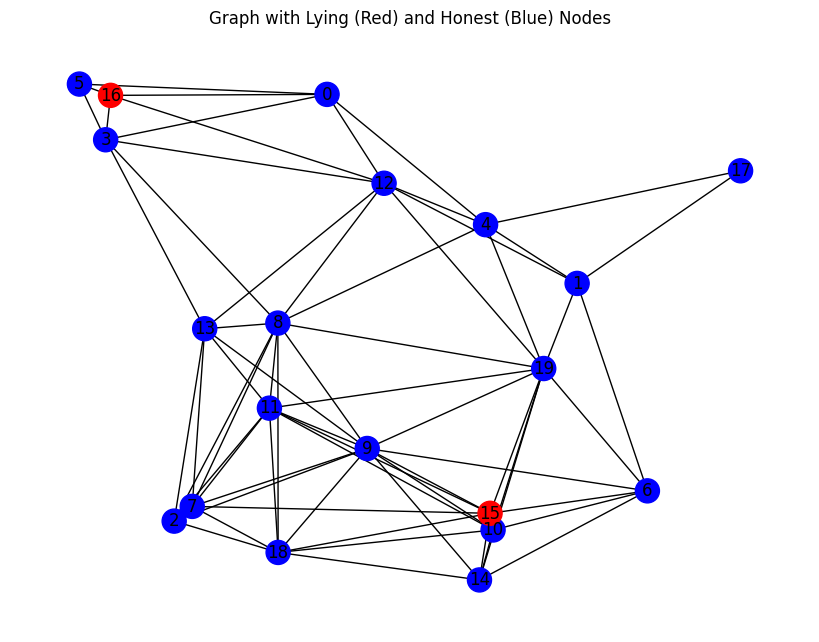

Are the honest-only nodes still forming a connected subgraph? True
All honest nodes have majority honest neighbors? True


c:\Users\za_re\anaconda3\envs\sklearn-env\Lib\site-packages\torch\nn\modules\module.py:1159: UserWarning: expandable_segments not supported on this platform (Triggered internally at ..\c10/cuda/CUDAAllocatorConfig.h:28.)
  return t.to(


20 clients with gradients 3
Iter   0 | FAR=1.000 | MDR=0.000 | loss=2.2600 | acc=13.27%


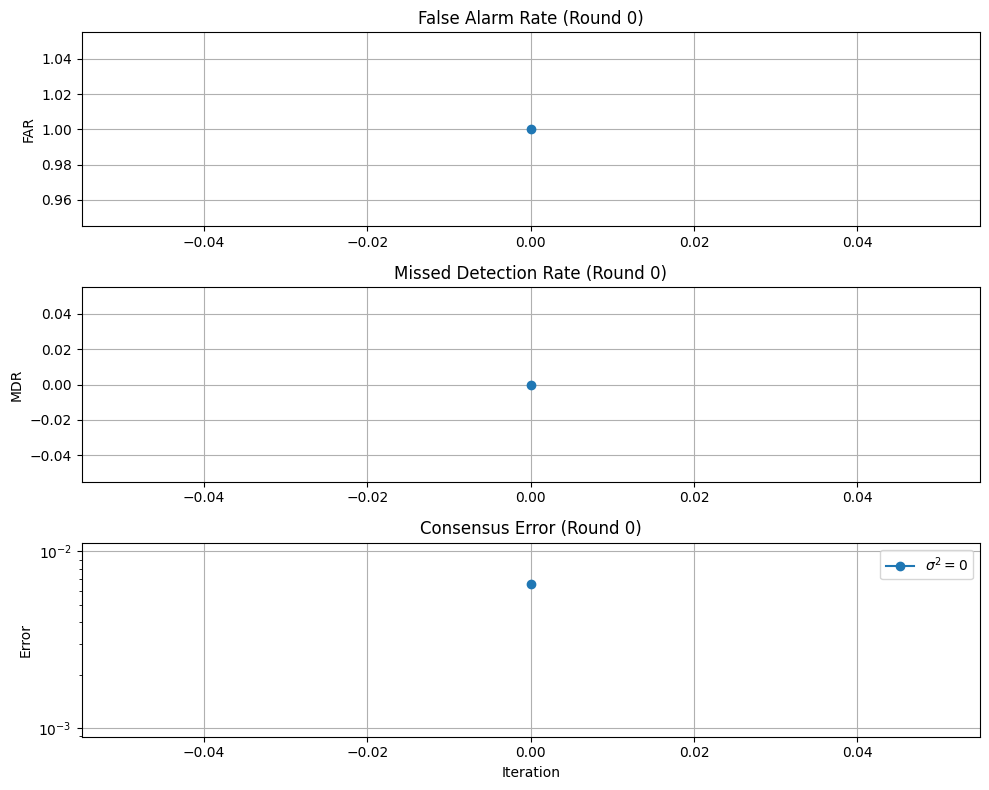

In [ ]:
import torch
from torch import amp
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, Subset
import matplotlib
# matplotlib.use('Agg')  # non-interactive backend
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random
import copy
import traceback
import itertools
import pickle
from pathlib import Path
# Custom imports; ensure these modules are in your PYTHONPATH
from UtilityGraph import *
from Defence import *
from Corruption import *
from UtilityMLP import *
import gc
import os
from contextlib import contextmanager
import warnings

# ───────────────────── results-persistence helpers ─────────────────────
from collections import defaultdict
from datetime import datetime

def append_result(entry, path="resultsFedAVG.pkl"):
    """
    Append *one* experiment result to the pickle file.
    Each call writes an independent pickle frame.
    """
    with open(path, "ab") as fh:           # binary-append mode
        pickle.dump(entry, fh, protocol=pickle.HIGHEST_PROTOCOL)


def _nested_dict() -> defaultdict:          # top-level → picklable
    return defaultdict(dict)

_RESULTS = defaultdict(_nested_dict)      

def _to_plain(obj):
    "Recursively turn defaultdicts into plain dicts."
    if isinstance(obj, defaultdict):
        obj = {k: _to_plain(v) for k, v in obj.items()}
    elif isinstance(obj, dict):
        obj = {k: _to_plain(v) for k, v in obj.items()}
    return obj


def save_results(path: str = "resultsFedAVG.pkl") -> None:
    """
    Persist global _RESULTS; merge under a timestamp if file exists.
    """
    ts_key = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

    # ➊ convert to plain dict to avoid defaultdict pickling woes
    clean_results = _to_plain(_RESULTS)

    payload = {ts_key: clean_results}

    p = Path(path)
    if p.exists():
        with p.open("rb") as fh:
            try:
                existing = pickle.load(fh)
            except Exception:
                existing = {}
        existing.update(payload)
        payload = existing

    tmp = p.with_suffix(".tmp")
    with tmp.open("wb") as fh:
        pickle.dump(payload, fh, protocol=pickle.HIGHEST_PROTOCOL)  # highest proto → smaller/faster
    tmp.replace(p)

    n_priv = len(clean_results)
    n_atk  = sum(len(a) for a in clean_results.values())
    n_noise = sum(len(n) for a in clean_results.values() for n in a.values())
    print(f"Saved {n_priv=} {n_atk=} {n_noise=} to {p} under key '{ts_key}'.")



# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gc.collect()
torch.cuda.empty_cache()

os.environ.setdefault(
    "PYTORCH_CUDA_ALLOC_CONF",
    "max_split_size_mb:128,expandable_segments:True"
)


@contextmanager
def cuda_guard(section: str = ""):
    """Wrap GPU-heavy blocks to catch OOM and clean up."""
    try:
        yield
    except torch.cuda.OutOfMemoryError as e:
        warnings.warn(
            f"[OOM in {section}] {e}.  Emptying cache and re-raising ...",
            RuntimeWarning
        )
        torch.cuda.empty_cache()
        gc.collect()
        raise

# class Current(nn.Module):
#     def __init__(self, input_size, hidden_size, num_classes):
#         super(Current, self).__init__()
        
#         self.layers = nn.Sequential(
#             nn.Linear(input_size, hidden_size),  # Layer 1
#             nn.ReLU(),
#             nn.Linear(hidden_size, hidden_size), # Layer 2
#             nn.ReLU(),
#             nn.Linear(hidden_size, hidden_size), # Layer 3
#             nn.ReLU(),
#             nn.Linear(hidden_size, hidden_size), # Layer 4
#             nn.ReLU(),
#             nn.Linear(hidden_size, hidden_size), # Layer 5
#             nn.ReLU(),
#             nn.Linear(hidden_size, hidden_size), # Layer 6
#             nn.ReLU(),
#             nn.Linear(hidden_size, num_classes)  # Output Layer (Layer 7)
#         )

#     def forward(self, x):
#         x = x.view(x.size(0), -1)  # Flatten the input
#         return self.layers(x)



class Current(nn.Module):
    """Two-layer MLP model."""
    def __init__(self, input_size, hidden_size, num_classes):
        super(Current, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

class FlipLabelDataset(Dataset):
    """Dataset wrapper that flips labels according to a fixed map."""
    def __init__(self, dataset):
        self.dataset = dataset
        self.label_map = {0:3,1:4,2:7,3:5,4:8,5:0,6:9,7:6,8:2,9:1}

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        flipped_label = self.label_map[label]
        return image, flipped_label


def split_dataset(dataset, num_clients):
    """Randomly split a dataset into `num_clients` subsets."""
    dataset_size = len(dataset)
    indices = np.random.permutation(dataset_size)
    data_per_client = dataset_size // num_clients
    split_sizes = [data_per_client] * num_clients
    for i in range(dataset_size % num_clients):
        split_sizes[i] += 1
    subsets = []
    start = 0
    for size in split_sizes:
        subsets.append(Subset(dataset, indices[start:start + size]))
        start += size
    return subsets


def plot_combined_metrics(results, round_idx, typeAttack, PrivacyMethod, save):
    """Plot FAR, MDR, and Consensus Error for different noise levels."""
    markers = ['o','s','d','^','v','<','>','p','*','h','+','x']
    # Group results by noise variance
    noise_groups = {}
    for res in results:
        key = 0 if PrivacyMethod == 2 else res.get('noise_STD', 0) or 0
        noise_groups.setdefault(key, []).append(res)

    sorted_noises = sorted(noise_groups.keys())
    fig, axs = plt.subplots(3,1,figsize=(10,8))
    base_markevery = 17

    # FAR
    for idx, noise in enumerate(sorted_noises):
        group = noise_groups[noise]
        far_matrix = np.array([r['FAR'] for r in group])
        avg_far = np.mean(far_matrix, axis=0)
        marker = markers[idx % len(markers)]
        offset = (idx*50) % base_markevery
        markevery = (offset, base_markevery)
        label = '$\\sigma^2 = 0$' if noise==0 else f'$\\sigma^2 = 10^{{{int(np.log10(noise))}}}$'
        if PrivacyMethod != 2:
            axs[0].plot(avg_far, marker=marker, markevery=markevery, label=label, markersize=6)
        else:
            axs[0].plot(avg_far, marker=marker, markevery=markevery, markersize=6)
    axs[0].set_title(f'False Alarm Rate (Round {round_idx})')
    axs[0].set_ylabel('FAR')
    axs[0].grid(True)

    # MDR
    for idx, noise in enumerate(sorted_noises):
        group = noise_groups[noise]
        mdr_matrix = np.array([r['MDR'] for r in group])
        avg_mdr = np.mean(mdr_matrix, axis=0)
        marker = markers[idx % len(markers)]
        offset = (idx*50) % base_markevery
        markevery = (offset, base_markevery)
        label = '$\\sigma^2 = 0$' if noise==0 else f'$\\sigma^2 = 10^{{{int(np.log10(noise))}}}$'
        if PrivacyMethod != 2:
            axs[1].plot(avg_mdr, marker=marker, markevery=markevery, label=label, markersize=6)
        else:
            axs[1].plot(avg_mdr, marker=marker, markevery=markevery, markersize=6)
    axs[1].set_title(f'Missed Detection Rate (Round {round_idx})')
    axs[1].set_ylabel('MDR')
    axs[1].grid(True)

    # Error
    for idx, noise in enumerate(sorted_noises):
        group = noise_groups[noise]
        err_matrix = np.array([r['Error'] for r in group])
        avg_err = np.mean(err_matrix, axis=0)
        marker = markers[idx % len(markers)]
        offset = (idx*50) % base_markevery
        markevery = (offset, base_markevery)
        if PrivacyMethod != 2:
            label = '$\\sigma^2 = 0$' if noise==0 else f'$\\sigma^2 = 10^{{{int(np.log10(noise))}}}$'
            axs[2].plot(avg_err, marker=marker, markevery=markevery, label=label, markersize=6)
        else:
            axs[2].plot(avg_err, marker=marker, markevery=markevery, markersize=6)
    axs[2].set_title(f'Consensus Error (Round {round_idx})')
    axs[2].set_ylabel('Error')
    axs[2].set_xlabel('Iteration')
    axs[2].set_yscale('log')
    axs[2].grid(True)
    if PrivacyMethod != 2:
        axs[2].legend()

    plt.tight_layout()
    if save:
        fname = f"combined_metrics_typeAttack{typeAttack}_PrivacyMethod{PrivacyMethod}_Round{round_idx}.png"
        plt.savefig(fname, dpi=300)
    plt.show()

def aggregate_models(client_datasets, node_models, G, tolerance, c, max_iters, rejection_threshold, K_decision, averaging, when, CorruptValue, true_nodes, Print_Val, noise_STD, PrivacyMethod, p, learning_rate, batch_size, input_size, hidden_size, num_classes, detect, log_filename, test_ds, criterion, save, CorruptClients, typeAttack, var_attack, mean, Target, scale, num_clients, perm_threshold=0.5):
    # Initialize variables
    num_nodes = len(node_models)
    converged = False
    count = 0
    Error = []
    Track = 0
    mask_history = []
    loss_list = []
    acc_list = []
    # lying_nodes = lying_nodes or set()
    global_dict = node_models[0].state_dict() 
    True_avg_dict = global_dict
    # True_avg_dict = True_avg.state_dict()
    iters = [iter(DataLoader(ds, batch_size=batch_size, shuffle=True, drop_last=True)) for ds in client_datasets]

    # Detection 
    # mask = np.ones((num_nodes, num_nodes), dtype=int)  # 1: active, -1: blocked
    # Start with all zeros
    mask = np.zeros((num_nodes, num_nodes), dtype=int)

    for i, j in G.edges():
        mask[i, j] = -1
        mask[j, i] = -1

    D = {i: {j: 0 for j in G.neighbors(i)} for i in G.nodes()}  # Suspicion scores
    ignored = {i: set() for i in G.nodes()}  # Ignored neighbors

    # Model parameter initialization
    local_dicts = [model.state_dict() for model in node_models]

    # param_keys = True_avg.keys()  # all models have the same parameters
    A_ij = calc_incidence_nested(G)
    x_history = []
    # Initialize PDMM variables with tensor support
    x = [{} for _ in range(num_nodes)]
    z = [{} for _ in range(num_nodes)]
    y = [{} for _ in range(num_nodes)]
    y_transmit = [{} for _ in range(num_nodes)]
    # Initialize x with local models and move to device
    for i in range(num_nodes):
        for key in True_avg_dict.keys():
                x[i][key] = local_dicts[i][key].clone()

    # Initialize z and y
    for i in range(num_nodes):
        z[i] = {}
        y[i] = {}
        y_transmit[i] = {}
        for j in G.neighbors(i):
            z[i][j] = {}
            y[i][j] = {}
            y_transmit[i][j] = {}
            for key in True_avg_dict.keys():
                if PrivacyMethod == 3:
                    z[i][j][key] = torch.randn_like(True_avg_dict[key]) * noise_STD
                else:
                    z[i][j][key] = torch.zeros_like(True_avg_dict[key])
                y[i][j][key] = torch.zeros_like(True_avg_dict[key])
                y_transmit[i][j][key] = torch.zeros_like(True_avg_dict[key])
         
    if PrivacyMethod == 2:
        smpc_masks = {}
        for i in range(num_nodes):
            for j in G.neighbors(i):
                if i < j:
                    smpc_masks[(i, j)] = {}
                    for key in True_avg_dict:
                        smpc_masks[(i, j)][key] = torch.randn_like(True_avg_dict[key])




    honest_nodes  = set(true_nodes)
    lying_nodes   = [n for n in range(num_nodes) if n not in honest_nodes]

    edges = list(G.edges())
    edges_honest_target  = [(i, j) for (i, j) in edges if j in honest_nodes]
    edges_corrupt_target = [(i, j) for (i, j) in edges if j in lying_nodes]

    total_honest_edges   = len(edges_honest_target)
    total_corrupt_edges  = len(edges_corrupt_target)

    FAR_list, MDR_list = [], []      # will grow one element per PDMM iteration

    # print(lying_nodes)
    # Synchronous PDMM with detection
    while not converged and count < max_iters:
        # -------------------------------------------------
        # 0) fresh local gradients g_i
        # -------------------------------------------------
        g = [{} for _ in range(num_nodes)]
        for i, model in enumerate(node_models):
          try:
            xb, yb = next(iters[i])
          except StopIteration:
            iters[i] = iter(DataLoader(client_datasets[i],
                                   batch_size=batch_size,
                                   shuffle=True, drop_last=True))
            xb, yb = next(iters[i])

          xb, yb = xb.to(device), yb.to(device)

          torch.cuda.empty_cache()                # <-- new: clear tiny fragments

        #   with cuda_guard("forward+backward"), amp.autocast(device_type="cuda"):
            #  loss = F.cross_entropy(model(xb), yb)
        
          with cuda_guard("forward+backward"):
            loss = F.cross_entropy(model(xb), yb)


          model.zero_grad()
          loss.backward()
          for n, p in model.named_parameters():
              g[i][n] = p.grad.detach().clone()

        torch.cuda.empty_cache() 

        #g = CorruptData(CorruptClients, g, typeAttack, var, mean, Target, num_nodes, scale)
        # for i in range(num_nodes):
        #     if CorruptClients[i]:
        #         total_norm = sum(torch.norm(g[i][k]) for k in g[i])
        #         print(f"Node {i}: grad norm = {total_norm:.2e}")

        # --------------------
        # 1. Synchronous x-update for all nodes
        # --------------------
        x_new = [{} for _ in range(num_nodes)]
        for i in range(num_nodes):
            # Count corrupt neighbors once for node i
            corrupt_neighbors = sum(1 for j in G.neighbors(i) if mask[i][j] == -1)
            effective_degree = G.degree[i] - corrupt_neighbors

            # Update each parameter using the same effective degree


            
            for key in True_avg_dict:
                num = local_dicts[i][key].clone() - learning_rate * g[i][key]
                for j in G.neighbors(i):
                    if mask[i][j] != -1:
                        num -= A_ij[i][j] * z[i][j][key]
                den = 1.0 + learning_rate * c * effective_degree 
                x_new[i][key] = num / den
        x = x_new
        x = CorruptData(CorruptClients, x , typeAttack, var_attack, mean, Target, num_nodes, scale)

        x_history.append(x.copy())

        # ---- Sync torch modules and local_dicts with the fresh PDMM solution ----
        for i in range(num_nodes):
            # build a plain state-dict for loading
            new_state = {k: v.clone() for k, v in x[i].items()}
            node_models[i].load_state_dict(new_state)   # so next gradient is ?F(w_i^{(k)})
            local_dicts[i] = new_state                  # num = w_i^{(k)} - a g_i^{(k)}
        # ------------------------------------------------------------------------

        # --------------------
        # 2. Dual variable update (y)
        # --------------------
        for i in range(num_nodes):
            for j in G.neighbors(i):
                for key in True_avg_dict:
                    y[i][j][key] = z[i][j][key] + 2 * c * A_ij[i][j] * x[i][key]
                    if PrivacyMethod == 1:
                        y[i][j][key].add_(torch.randn_like(local_dicts[i][key]) * noise_STD)



        if PrivacyMethod == 2:
            # SMPC: Apply pairwise masks for secure aggregation
            for i in range(num_nodes):
                for j in G.neighbors(i):
                    for key in True_avg_dict:
                        if i < j:
                            y_transmit[i][j][key] = y[i][j][key] + smpc_masks[(i, j)][key]
                        else:
                            y_transmit[i][j][key] = y[i][j][key] - smpc_masks[(j, i)][key]
        else:
            # Original: no additional masking
            for i in range(num_nodes):
                for j in G.neighbors(i):
                    for key in True_avg_dict:
                         y_transmit[i][j][key] = y[i][j][key].clone()


        # --------------------
        # 3. Detection logic (executed periodically)
        # --------------------
        # if count > when:
        #print(f"Detecting at count {count}")
        if detect == True:
          for i in range(num_nodes):
              neighbors = [j for j in G.neighbors(i) if j not in ignored[i]]
              if not neighbors:
                  continue
  
              # Precompute absolute values of y variables (for PDMM minus-sign handling)
              abs_y = {j: {key: torch.abs(y_transmit[j][i][key]) for key in True_avg_dict} for j in neighbors}

              # 1. Compute element-wise median (m_i)
              medians = {}
              for key in True_avg_dict:
                  # Stack all neighbors' parameters for this key
                  params = torch.stack([abs_y[j][key] for j in neighbors])
                  medians[key] = torch.median(params, dim=0).values  # Element-wise median

              # 2. Compute Delta Y_{i,j} using infinity norm
              delta_ys = []
              for j in neighbors:
                  max_diff = -float('inf')
                  for key in True_avg_dict:
                      diff = torch.max(torch.abs(abs_y[j][key] - medians[key])).item()
                      if diff > max_diff:
                          max_diff = diff
                  delta_ys.append(max_diff)

              # 3. Compute MAD and threshold
              median_delta = np.median(delta_ys)
              deviations = np.abs(delta_ys - median_delta)
              MAD_val = np.median(deviations)
              threshold = rejection_threshold * MAD_val
              epsilon = 1e-12  
              threshold = max(threshold, epsilon) # TO avaoid zero threshold

              # 4. Update suspicion scores
              for idx, j in enumerate(neighbors):
                #   if j in lying_nodes:
                  # print(f"Node {i} check {j}: ?Y={delta_ys[idx]:.2f}, threshold={threshold:.2f}")
                  if delta_ys[idx] > threshold:
                #   if j in lying_nodes:
                      D[i][j] += 1
                    #   print(f"To {i} Value of {j}: ?Y={delta_ys[idx]:.8f}, threshold={threshold:.8f}, D = {D[i][j]}")
                  # if j in lying_nodes:
                      # if Print_Val:
                      # print(f"Node {i} suspicious of {j}: ?Y={delta_ys[idx]:.2f}, threshold={threshold:.2f}, D = {D[i][j]}")

              # 5. Periodic mitigation check
              if count % K_decision == 0 and count > 0:
                  for j in list(D[i].keys()):  # Iterate over copy to allow modification
                      if D[i][j] > K_decision/2:
                          # print(f"Node {i} ignoring node {j} for next {K_decision} iterations")
                          mask[i][j] = -1
                      else:
                          mask[i][j] = 1
                      D[i][j] = 0
        mask_history.append(mask.copy())

        false_alarms       = sum(1 for (i, j) in edges_honest_target  if mask[i, j] == -1)
        missed_detections  = sum(1 for (i, j) in edges_corrupt_target if mask[i, j] != -1)

        far = false_alarms      / total_honest_edges  if total_honest_edges  else 0.0
        mdr = missed_detections / total_corrupt_edges if total_corrupt_edges else 0.0

        FAR_list.append(far)
        MDR_list.append(mdr)

        # --------------------
        # 4. Synchronous z-update with masking
        # --------------------

        if PrivacyMethod == 2:
            for i in range(num_nodes):
                for j in G.neighbors(i):
                    if mask[i][j] == -1:
                        for key in True_avg_dict:
                            z[i][j][key] = (1 - averaging) * z[i][j][key] 
                    if mask[i][j] == 1:
                        for key in True_avg_dict:
                            if j < i:
                                unmasked = y_transmit[j][i][key] + smpc_masks[(j, i)][key]
                            else:
                                unmasked = y_transmit[j][i][key] - smpc_masks[(i, j)][key]
                            z[i][j][key] = (1 - averaging) * z[i][j][key] + (averaging) * unmasked
        else:                        
          for i in range(num_nodes):
              for j in G.neighbors(i):
                if mask[i][j] == -1:
                      # Apply noise to blocked channels
                    for key in True_avg_dict:
                        z[i][j][key] = (1 - averaging) * z[i][j][key] 
                if mask[i][j] == 1:
                    # Normal update from y values
                    for key in True_avg_dict:
                        z[i][j][key] = (1 - averaging) * z[i][j][key]  + (averaging) * y_transmit[j][i][key].clone()


        # --------------------
        # 5. Update global model and check convergence
        # --------------------
        avg_error = 0
        err_i = 0
        total_elements = 0

        for i in true_nodes:
            node_error = 0
            for key in True_avg_dict:
                diff = x[i][key] - True_avg_dict[key]
                norm_diff = torch.norm(diff).item()**2
                node_error += norm_diff
            err_i += node_error
            avg_error = err_i**0.5
            total_elements += 1

        # Final norm: average error divided by the total number of nodes
        avg_error /= total_elements

        # Store the computed average error
        Error.append(avg_error)
        # if count % 100 == 0:
        #     loss1, acc = evaluate(node_models, test_ds, criterion, batch_size)
        #     print(f"Iter {count:3d} | FAR={far:.3f} | MDR={mdr:.3f} | loss={loss:.4f} | acc={acc:.2f}%")
        #     loss_list.append(loss)
        #     acc_list.append(acc) 
        #     print(f"cunt {count} and error {Error[-1]}" )

        if avg_error < tolerance:
            print(f'Converged at iteration {count}')
            converged = True
        elif count % 10 == 0 and Print_Val:
            print(f'Iter {count}: Error {avg_error:.4f}')

        # ─── inside the while-loop, right after you update FAR/MDR/Error ─────────────
        # adaptive evaluation frequency: 0–50 iters → every 5; 50–199 → 10; 200+ → 20
        if   count < 50:      eval_every = 5
        elif count < 200:     eval_every = 10
        else:                 eval_every = 20

        if count % eval_every == 0:
            honest_models = [node_models[i] for i in true_nodes]
            loss1, acc = evaluate(honest_models, test_ds, criterion, batch_size)
            print(f"Iter {count:3d} | FAR={far:.3f} | MDR={mdr:.3f} | "
                f"loss={loss1:.4f} | acc={acc:.2f}%")
            loss_list.append(loss1)
            acc_list.append(acc)

        # ─── logging (only once per evaluation) ──────────────────────────────────────
        if save and count % eval_every == 0:
            with open(log_filename, "a") as logfile:
                logfile.write(
                    f"Iter {count:3d}  FAR={far:.3f} | MDR={mdr:.3f} | "
                    f"loss={loss1:.4f} | acc={acc:.2f}%\n"
                )

        count += 1
        # ─────────────────────────────────────────────────────────────────────────────


        # if save == True:
        #     with open(log_filename, "a") as logfile:
        #         logfile.write(f"Round {count}  FAR={far:.3f} | MDR={mdr:.3f} | loss={loss1:.4f} | acc={acc:.2f}%")
        # count += 1


    # Update final models
    for i in range(num_nodes):
        model_dict = node_models[i].state_dict()
        for key in True_avg_dict:
            model_dict[key] = x[i][key].clone()
        node_models[i].load_state_dict(model_dict)


            

    # Create an averaged model with the final True_avg_dict
    averaged_model = type(node_models[0])(input_size, hidden_size, num_classes).to(device)  # Pass necessary arguments directly
    averaged_model.load_state_dict(True_avg_dict)
    

    return node_models, Error, FAR_list, MDR_list, mask_history, loss_list, acc_list

    
def evaluate(models, test_dataset, criterion, batch_size):
    """Evaluate one or multiple models on the test set."""
    loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    if not isinstance(models, (list, tuple)):
        models = [models]
    total_loss, total_acc = 0.0, 0.0
    for model in models:
        model.to(device).eval()
        loss_sum, correct, count = 0.0, 0, 0
        with torch.no_grad():
            for imgs, labels in loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss_sum += criterion(outputs, labels).item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
                count += labels.size(0)
        total_loss += loss_sum / len(loader)
        total_acc += 100 * correct / count
    return total_loss / len(models), total_acc / len(models)
    
    
def main():
    # Reproducibility
    Seed = 42  # for reproducibility
    random.seed(Seed)
    np.random.seed(Seed)
    torch.manual_seed(Seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(Seed)
        torch.cuda.manual_seed_all(Seed)

    # Graph setup
    required_probability = 0.9999
    Amount_Clients = 20
    num_nodes, G, A, pos, r_c = build_random_graph(
        Amount_Clients, required_probability, fix_num_nodes=True
    )
    print("num_nodes:", num_nodes)

    # Hyperparameters
    input_size = 28 * 28        # MNIST images are 28x28 pixels
    hidden_size = 128           # Number of neurons in the hidden layer
    num_classes = 10            # Number of output classes (digits 0-9)
    # num_epochs = 5              # Number of local training epochs per aggregation
    batch_size = 64             # Batch size for training
    learning_rate = 0.01        # Learning rate for the optimizer
    num_clients = num_nodes     # Number of clients
    num_rounds = 1              # Number of aggregation rounds
    # threshold = 0.02            # Loss threshold for stopping criteria

    # Corruption settings
    percentageCorrupt = 2 / num_nodes
    corrupt = True
    detect = True
    save = True
    CorruptClients = CorruptGeneration(
        percentageCorrupt, corrupt, num_clients
    )
    lying_nodes = np.where(CorruptClients == 1)[0]
    true_nodes = [i for i in range(num_nodes) if i not in lying_nodes]
    print("Corrupt Clients:", lying_nodes)
    # print(num_clients)
    tolerance = -1               # PDMM tolerance
    c = 0.5                      # PDMM c
    max_iters =  1           # PDMM max iterations


    when = 0
    CorruptValue = -1e17
    rejection_threshold = 20
    K_decision = 6
    averaging = 1
    noise_levels = [0]  # Noise levels for Gaussian noise

    var_attack = 10**2
    mean = 0
    Target = np.random.randint(1, num_clients)
    scale = 1
    typeAttackArray = [0] # 0:No attack , 1: Gaussian noise, 2: Copycat attack, 3: Gaussian addative noise attack, 4: LIE attack, 5 Sign flip attack, 6: Label Flipping attack
    PrivacyMethodArray = [3] # 0: No privacy, 1: DP, 2: SMPC, 3: Subspace
    p = 0
    PrimModulo = [0]
    print(CorruptClients)
    for typeAttack in typeAttackArray:
      for PrivacyMethod in PrivacyMethodArray:
            
        # Visualize graph
        neighbors_dict = {ln: list(G.neighbors(ln)) for ln in lying_nodes}
        print("Neighbors of lying nodes:", neighbors_dict)
        plt.figure(figsize=(8,6))
        color_map = ['red' if n in lying_nodes else 'blue' for n in G.nodes()]
        nx.draw(G, pos, with_labels=True, node_color=color_map)
        plt.title("Graph with Lying (Red) and Honest (Blue) Nodes")
        plt.show()

        # Honest-only connectivity checks
        remaining_nodes = [n for n in G.nodes() if n not in lying_nodes]
        G_sub = G.subgraph(remaining_nodes)
        still_connected = nx.is_connected(G_sub)
        print("Are the honest-only nodes still forming a connected subgraph?", still_connected)

        all_good = True
        for node in remaining_nodes:
            neighbors = list(G.neighbors(node))
            if neighbors:
                honest_neighbors = sum(1 for nb in neighbors if nb not in lying_nodes)
                if honest_neighbors <= len(neighbors)/2:
                    print(f"Honest node {node} has only {honest_neighbors}/{len(neighbors)} honest neighbors")
                    all_good = False
        print("All honest nodes have majority honest neighbors?", all_good)

        # Data loading
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
        train_ds = torchvision.datasets.FashionMNIST(
            root='./data', train=True, transform=transform, download=True
        )
        test_ds = torchvision.datasets.FashionMNIST(
            root='./data', train=False, transform=transform, download=True
        )
        client_datasets = split_dataset(train_ds, num_clients)
    
        # Optional label flipping
        for idx in lying_nodes:
            if typeAttack == 6:
                client_datasets[idx] = FlipLabelDataset(client_datasets[idx])

        # Initialize models
        init_w = Current(input_size, hidden_size, num_classes).state_dict()
        local_models = []
        for _ in range(num_clients):
            m = Current(input_size, hidden_size, num_classes).to(device)
            m.load_state_dict(init_w)
            m.train()
            local_models.append(m)

        # Training/aggregation loop
        criterion = nn.CrossEntropyLoss()
        results = []
        for noise in noise_levels:
            if save == True:
                log_filename = f"results_PDMM_Attack{typeAttack}_Privacy{PrivacyMethod}_Noise{noise}.txt"
            for rnd in range(num_rounds):
                # Apply corruption
                # local_models = CorruptData(
                #     CorruptClients, local_models,
                #     typeAttack, var, mean, Target,
                #     num_clients, scale
                # )
                # Aggregate via PDMM
                print(num_clients, "clients with gradients 3")
                updated, err_hist, FAR_list, MDR_list, mask_history, loss_list, acc_list = aggregate_models(
                        client_datasets, local_models, G,
                        tolerance, c, max_iters, rejection_threshold,
                        K_decision, averaging, when, CorruptValue,
                        true_nodes, False, noise, PrivacyMethod,
                        p, learning_rate, batch_size, input_size, hidden_size,
                        num_classes, detect, log_filename, test_ds, criterion, save, 
                        CorruptClients, typeAttack, var_attack, mean, Target, num_clients, scale)

        

            result_dict = {
                    "timestamp": datetime.now().isoformat(timespec="seconds"),
                    "privacy":   PrivacyMethod,
                    "attack":    typeAttack,
                    "noise":     noise,
                    "FAR":       FAR_list,
                    "MDR":       MDR_list,
                    "Error":     err_hist,
                    "loss":      loss_list,
                    "accuracy":  acc_list,
            }
            # 1) keep it in-memory if you still want the combined figure
            results.append(result_dict)

            # 2) write it permanently right now
            append_result(result_dict)          # ← NEW, one line


        plot_combined_metrics(
                results, round_idx=rnd,
                typeAttack=typeAttack,
                PrivacyMethod=PrivacyMethod, save=save)
        


if __name__ == "__main__":
    main()



In [ ]:
import os
import pickle
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PickleFile ="results.pkl" 
PickleFile = "resultsFedAVG.pkl" 
# PickleFile ="resultsFedAVGNew.pkl" 


# ------------------------------------------------------------------
# helper: which rounds were evaluated?
# ------------------------------------------------------------------
def _evaluation_steps(n_rounds):
    """Return the list [0, 5, 10, …] according to your eval_every rule."""
    steps = []
    for r in range(n_rounds):
        if r < 50:
            eval_every = 5
        elif r < 200:
            eval_every = 10
        else:
            eval_every = 20
        if r % eval_every == 0:
            steps.append(r)
    return steps


# ------------------------------------------------------------------
# safe getter: returns lst[i] if in range, else None
# ------------------------------------------------------------------
def _safe_step(lst, i):
    return lst[i] if lst and i < len(lst) else None

# ------------------------------------------------------------------
# 1. load every pickle “frame”
# ------------------------------------------------------------------
def load_all_results_stream(path=PickleFile):
    blocks = []
    with Path(path).open("rb") as fh:
        while True:
            try:
                blocks.append(pickle.load(fh))
            except EOFError:
                break
    return blocks

# ------------------------------------------------------------------
# 2. expand each block into step-wise rows
# ------------------------------------------------------------------
def build_long_df(blocks):
    rows = []
    fixed_keys = {
        'timestamp','privacy','attack',
        'loss','accuracy','FAR','MDR','Error',
        'train_loss','train_accuracy',
        'test_loss','test_accuracy',
        'test_loss2','test_accuracy2'
    }

    for f in blocks[:3]:          # print first 3 frames
        print(len(f["train_accuracy"]), len(f["test_accuracy"]))


    for blk in blocks:
        # ---- meta columns -------------------------------------------------
        meta = {
            "timestamp": blk.get("timestamp"),
            "privacy":   blk.get("privacy"),
            "attack":    blk.get("attack"),
            **{k: blk[k] for k in blk if k not in fixed_keys}
        }

        # ---- how many training rounds?  (== len(train_accuracy)) ----------
        n_rounds = len(blk.get("train_accuracy", []))
        if n_rounds == 0:                       # fall-back: longest list
            n_rounds = max(len(blk.get(k, [])) for k in (
                "loss","accuracy","FAR","MDR","Error","train_loss"))

        eval_steps = _evaluation_steps(n_rounds)            # [0,5,10,…]

        # ---- build maps ROUND → value for test-metrics --------------------
        def _to_map(key):
            vals = blk.get(key, [])
            return {step: v for step, v in zip(eval_steps, vals)}

        test_loss_map        = _to_map("test_loss")
        test_accuracy_map    = _to_map("test_accuracy")
        test_loss2_map       = _to_map("test_loss2")
        test_accuracy2_map   = _to_map("test_accuracy2")

        # ---- create one DataFrame row per *round* -------------------------
        for step in range(n_rounds):
            rows.append({
                **meta,
                "step": step,                    # TRUE round index
                "loss":             blk.get("loss",            [None]*n_rounds)[step] if step < len(blk.get("loss", [])) else None,
                "accuracy":         blk.get("accuracy",        [None]*n_rounds)[step] if step < len(blk.get("accuracy", [])) else None,
                "FAR":              blk.get("FAR",             [None]*n_rounds)[step] if step < len(blk.get("FAR", [])) else None,
                "MDR":              blk.get("MDR",             [None]*n_rounds)[step] if step < len(blk.get("MDR", [])) else None,
                "Error":            blk.get("Error",           [None]*n_rounds)[step] if step < len(blk.get("Error", [])) else None,
                "train_loss":       blk.get("train_loss",      [None]*n_rounds)[step] if step < len(blk.get("train_loss", [])) else None,
                "train_accuracy":   blk.get("train_accuracy",  [None]*n_rounds)[step] if step < len(blk.get("train_accuracy", [])) else None,
                # ---- TEST-metrics use the *maps* -------------------------
                "test_loss":        test_loss_map.get(step),
                "test_accuracy":    test_accuracy_map.get(step),
                "test_loss2":       test_loss2_map.get(step),
                "test_accuracy2":   test_accuracy2_map.get(step),
            })

            
    # Let Pandas treat missing numbers as NaN, not None
    return (pd.DataFrame(rows)
              .replace({None: np.nan}))

# ------------------------------------------------------------------
# 3. helper: draw ONE figure given a pivoted table + metric list
# ------------------------------------------------------------------
# ------------------------------------------------------------------
# 3. helper: draw ONE figure given a pivoted table + metric list
#            ✨ now with automatic Error-axis zoom ✨
# ------------------------------------------------------------------
def _plot_metrics(tbl, metrics, title, fname=None,
                  param_level="param",  *,
                  error_cap=95):          # <-- new kw-arg
    n = len(metrics)
    fig, axs = plt.subplots(1, n, figsize=(6*n, 4), sharex=True)
    if n == 1:
        axs = [axs]

    # ── pretty label for noise parameter ────────────────────────────
    pretty_param = r'$\sigma^{2}$' if param_name == 'noise_STD' else param_name

    sweep_vals = sorted(tbl.index.get_level_values(param_level).unique())
    markers = ['o','s','d','^','v','<','>','p','*','h','+','x']
    marker_spacing = 34

    # collect all y-values → we can decide axis limits afterwards
    collected = {m: [] for m in metrics}

    # ── inside _plot_metrics … keep everything above this unchanged ──────────
    for idx, val in enumerate(sweep_vals):
        pivot   = tbl.xs(val, level=param_level)
        marker  = markers[idx % len(markers)]
        var_lbl = f"{pretty_param}={val}"
        offset  = (idx * 15) % marker_spacing
        markevery = list(range(offset, len(pivot), marker_spacing))

        for m, ax in zip(metrics, axs):
            if m not in pivot.columns:
                continue

            y = pivot[m].values
            x = pivot.index.values

        # ---------------------------------------------------------------
        # TEST-metrics: draw *only* the finite points,
        #               marker at every point, connect with a line
        # ---------------------------------------------------------------
            if m.startswith("test_"):
                finite = ~np.isnan(y)
                ax.plot(
                    x[finite], y[finite],
                    marker=marker, markersize=6, linestyle='-',
                    label=var_lbl
                )
        # ---------------------------------------------------------------
        # all other metrics (FAR, MDR, Error, train/val): keep old style
        # ---------------------------------------------------------------
            else:
                ax.plot(
                    x, y,
                    marker=marker, linestyle='-',
                    markevery=markevery, markersize=5,
                    label=var_lbl
                )

            collected[m].extend(y)    # still gather for axis scaling


    # ── cosmetics per subplot ───────────────────────────────────────
    for m, ax in zip(metrics, axs):
        ylabel = m.capitalize() if not m.endswith("loss") else "Loss"
        ax.set_ylabel(ylabel)
        ax.grid(True)
        if 'loss' in m:
            ax.set_yscale("log")

        # *** NEW: tighten “Error” axis by dropping the top {error_cap}% ***
        if m.lower() == "error" and collected[m]:
            upper = np.nanpercentile(collected[m], error_cap)
            lower = np.nanpercentile(collected[m], 0)  # min without NaNs
            ax.set_ylim(lower, upper * 1.05)           # 5 % head-room

    # shared x-label
    axs[-1].set_xlabel("Iteration")
    axs[0].set_xlabel("Iteration")

    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels,
               loc="upper right", bbox_to_anchor=(1.00, 0.98),
               frameon=True)

    fig.suptitle(title)
    fig.tight_layout(rect=[0, 0, 0.88, 0.95])

    if fname:
        fig.savefig(fname, dpi=300)
        print("saved ➜", fname)
    plt.show()


# ------------------------------------------------------------------
# 4. main plotting wrapper
# ------------------------------------------------------------------
def plot_sweep(df_long, attack, privacy,
               param_name,    # e.g. 'noise_STD' or 'p'
               save=False,
               out_dir="plots"):
    subset = (df_long
                .query("attack == @attack and privacy == @privacy")
                .set_index([param_name, "step"])
                .sort_index())
    if subset.empty:
        print(f"No rows for attack={attack}, privacy={privacy}")
        return

    # ── 1. pick a nice display name ──────────────────────────────────
    pretty_param = r'$\sigma^{2}$' if param_name == 'noise_STD' else param_name
    #         ^^^^^^^^^^^^^^^^^^^     LaTeX: sigma squared
    
    metric_cols = [
        "FAR", "MDR", "Error",
        "accuracy", "loss",
        "train_accuracy", "train_loss",
        "test_accuracy",  "test_loss",
        "test_accuracy2", "test_loss2"
    ]
    mean_tbl = (subset[metric_cols]
                  .groupby(level=[param_name, "step"])
                  .mean(numeric_only=True))

    if save:
        os.makedirs(out_dir, exist_ok=True)

    base = f"attack{attack}_privacy{privacy}"
    metric_groups = [
        (["FAR", "MDR"],           "Detection metrics"),
        (["accuracy", "loss"],     "Validation performance"),
        (["train_accuracy", "train_loss"], "Training performance"),
        (["test_accuracy", "test_loss"],    "Test performance"),
        (["test_accuracy2", "test_loss2"],  "Test2 performance"),
        (["Error"],                "Error over iterations"),
    ]

    for metrics, desc in metric_groups:
        fname = None
        if save:
            safe = desc.replace(" ", "_").lower()
            fname = os.path.join(out_dir,
                                 f"{safe}_{param_name}_{base}.png")
        _plot_metrics(
            mean_tbl,
            metrics=metrics,
            title=f"{desc} ",
            fname=fname,
            param_level=param_name
        )

# ------------------------------------------------------------------
# 5. load data, build DataFrame, and call plotting
# ------------------------------------------------------------------
if __name__ == "__main__":
    # 1) load your pickled results
    blocks = load_all_results_stream(PickleFile)

    # 2) expand to long form safely
    df_long = build_long_df(blocks)

    # 3) choose param_name used in your experiments
    #    e.g. 'p' for PrivacyMethod==2, else 'noise_STD'
    param_name = 'noise_STD'

    # 4) plot & save
    plot_sweep(
        df_long,
        attack=3,
        privacy=3,
        param_name=param_name,
        save=True,
        out_dir="all_plots"
    )


50 10
50 10
50 10
No rows for attack=3, privacy=3


C:\Users\za_re\AppData\Local\Temp\ipykernel_21468\3488655125.py:118: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({None: np.nan}))


In [332]:
import pickle

# 1. Load all entries
results = []
with open(PickleFile, 'rb') as f:
    while True:
        try:
            results.append(pickle.load(f))
        except EOFError:
            break

# 2. Print a summary line for each entry
for i, res in enumerate(results):
    attack  = res.get('attack')
    privacy = res.get('privacy')
    # depending on privacy, the hyper‐param key is either 'noise_STD' or 'p'
    param_name = 'p' if privacy == 2 else 'noise_STD'
    param_val  = res.get(param_name, None)
    print(f"Entry {i:2d} → attack={attack}, privacy={privacy}, {param_name}={param_val}")


Entry  0 → attack=0, privacy=3, noise_STD=0
Entry  1 → attack=0, privacy=3, noise_STD=0.0001
Entry  2 → attack=0, privacy=3, noise_STD=0.01


In [333]:
import pickle, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict

# --- edit if your file lives elsewhere ---
PICKLE_PATH = Path(PickleFile)

def load_all_frames(pkl_path: Path):
    """Read *every* pickle object stored in the file into a list."""
    frames = []
    with pkl_path.open("rb") as fh:
        while True:
            try:
                frames.append(pickle.load(fh))
            except EOFError:
                break
    return frames

frames = load_all_frames(PICKLE_PATH)
print(f"Loaded {len(frames)} result frames ✅")
privacies = sorted({f["privacy"] for f in frames})
attacks   = sorted({f["attack"]  for f in frames})

print("Available privacies:", privacies)
print("Available attacks:  ", attacks)


Loaded 3 result frames ✅
Available privacies: [3]
Available attacks:   [0]


In [334]:
# <<< CHANGE THESE TWO LINES AS YOU LIKE >>>
PRIVACY_WANTED = privacies[0]   # e.g. 3
ATTACK_WANTED  = attacks[0]     # e.g. 0
# <<< ------------------------------------ >>>

subset = [f for f in frames
          if f["privacy"] == PRIVACY_WANTED and f["attack"] == ATTACK_WANTED]

if not subset:
    raise ValueError("❌  No runs found for this privacy / attack combination!")

param_key = "noise_STD" if "noise_STD" in subset[0] else "p"
print(f"Using parameter '{param_key}' to distinguish noise levels.")


Using parameter 'noise_STD' to distinguish noise levels.


In [335]:
def group_by_param(frames, key):
    groups = defaultdict(list)
    for f in frames:
        groups[f[key]].append(f)
    return groups

def stack_metric(frames, metric):
    """
    Return a dense 2-D array (runs × steps).

    Works for:
      • list-of-lists   (FAR, MDR)
      • single list     (Error, …)
      • single scalar   (rare corner cases)
    """
    seqs = []

    for f in frames:
        block = f.get(metric)
        if block is None:
            continue

        # ── Case 1: list/ndarray
        if isinstance(block, (list, tuple, np.ndarray)):
            # nested?  e.g. FAR = [[…],[…],…]
            if block and isinstance(block[0], (list, tuple, np.ndarray)):
                seqs.extend(block)          # many runs
            else:
                seqs.append(block)          # one run
        else:
            # ── Case 2: single scalar
            seqs.append([block])            # wrap in list

    if not seqs:
        raise ValueError(f"No data for metric '{metric}'")

    max_len = max(len(s) for s in seqs)
    data    = np.full((len(seqs), max_len), np.nan)

    for i, s in enumerate(seqs):
        data[i, :len(s)] = s

    return data                               # shape  (runs, steps)


# ------------------------------------------------------------------
# Plot mean ± 1 σ band
#   FAR / MDR → band clipped to [0, 1]
#   Error     → optional log scale + percentile zoom
#   NEW       → markers every N points, different shape per noise level
# ------------------------------------------------------------------
def plot_metric(metric, groups, *,
                sigma_alpha=0.25,
                clip_bounds=True,
                log_error=False,
                marker_spacing=34,
                smooth_window=5,
                show_final_line=True):
    """
    Plot smoothed median with 10–90 percentile band for all steps.

    Parameters
    ----------
    metric : str
        Metric to visualize, e.g. 'FAR', 'MDR', 'Error'
    groups : dict
        {param_val: [result_frames, …]}
    sigma_alpha : float
        Transparency of percentile band
    clip_bounds : bool
        Clip to [0, 1] for bounded metrics like FAR, MDR
    log_error : bool
        Log y-axis for 'Error'
    marker_spacing : int
        Distance between markers
    smooth_window : int
        Size of moving average window
    show_final_line : bool
        Whether to annotate final median with horizontal line
    """
    import numpy as np
    import matplotlib.pyplot as plt

    def smooth(arr, window):
        if len(arr) < window:
            return arr
        return np.convolve(arr, np.ones(window)/window, mode='same')

    markers = ['o', 's', 'd', '^', 'v', '<', '>', 'p', '*', 'h', '+', 'x']
    pretty_param = r'$\sigma^{2}$' if param_key == 'noise_STD' else param_key

    fig, ax = plt.subplots(figsize=(8, 5))
    y_collect = []

    for idx, param_val in sorted(enumerate(groups)):
        data = stack_metric(groups[param_val], metric)
        median = np.nanmedian(data, axis=0)
        p10    = np.nanpercentile(data, 10, axis=0)
        p90    = np.nanpercentile(data, 90, axis=0)

        # ── Bound clipping ──
        if clip_bounds and metric.upper() in ("FAR", "MDR"):
            p10 = np.maximum(p10, 0.0)
            p90 = np.minimum(p90, 1.0)

        # ── Avoid log(0) ──
        if metric.lower() == "error" and log_error:
            eps = np.nanmin(p90[p90 > 0]) * 1e-3 if np.any(p90 > 0) else 1e-12
            p10 = np.where(p10 <= 0, eps, p10)
            p90 = np.where(p90 <= 0, eps, p90)

        y_collect.extend(p10)
        y_collect.extend(p90)

        # ── Smooth median ──
        smoothed_median = smooth(median, smooth_window)

        # ── Plot ──
        x = np.arange(len(median))
        marker = markers[idx % len(markers)]
        offset = (idx * 15) % marker_spacing
        markevery = list(range(offset, len(median), marker_spacing))

        ax.plot(x, smoothed_median, lw=2,
                marker=marker, markersize=5, markevery=markevery,
                label=f"{pretty_param}={param_val**2}")
        ax.fill_between(x, p10, p90, alpha=sigma_alpha)

        # ── Optional final median line ──
        if show_final_line:
            final_val = np.nanmedian(data[:, -10:], axis=0).mean()
            ax.axhline(final_val, linestyle='--', alpha=0.3, linewidth=1)

    # ── Log scale for Error ──
    if metric.lower() == "error" and log_error:
        ax.set_yscale("log")

    # ── Final formatting ──
    ax.set_xlabel("PDMM iteration (step)")
    ax.set_ylabel(metric)
    ax.set_title(f"{metric}  –  privacy={PRIVACY_WANTED}, attack={ATTACK_WANTED}")
    ax.grid(True)
    ax.legend()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.840))
    fig.tight_layout()
    plt.show()


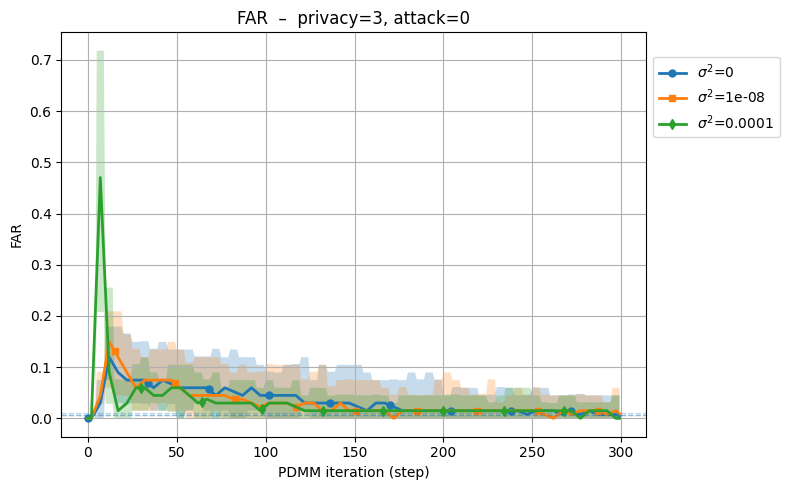

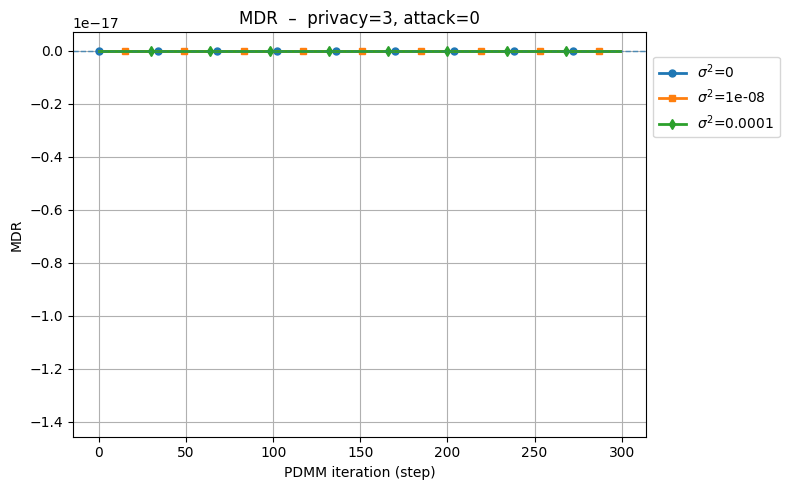

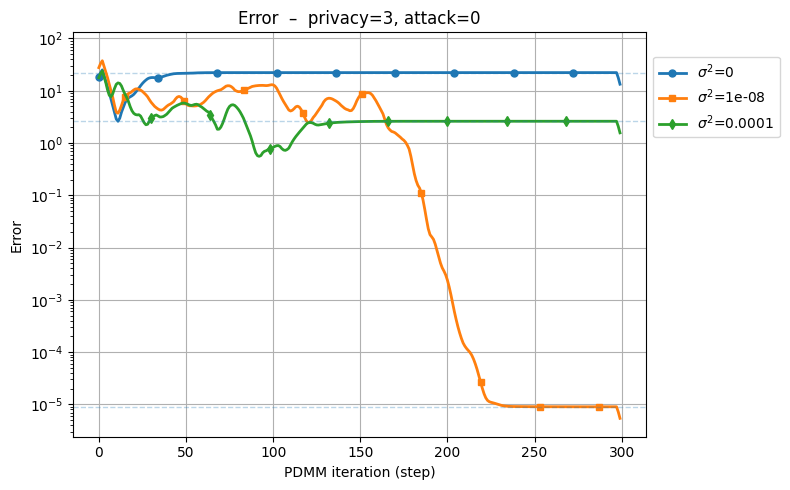

In [336]:
groups = group_by_param(subset, param_key)

plot_metric("FAR",   groups)          # as before
plot_metric("MDR",   groups)          # as before
plot_metric("Error", groups, log_error=True)   # 👈 log scale




In [337]:
import ipywidgets as widgets

def interactive_plots(privacy, attack):
    subset = [f for f in frames
              if f["privacy"] == privacy and f["attack"] == attack]
    if not subset:
        print("No data for this combination."); return

    global param_key          # reuse helpers above
    param_key = "noise_STD" if "noise_STD" in subset[0] else "p"
    groups = group_by_param(subset, param_key)

    plot_metric("FAR", groups)
    plot_metric("MDR", groups)
    plot_metric("Error", groups, log_error=True)   # 👈 log scale


widgets.interact(
    interactive_plots,
    privacy=widgets.Dropdown(options=privacies, description="Privacy"),
    attack =widgets.Dropdown(options=attacks,   description="Attack")
)


interactive(children=(Dropdown(description='Privacy', options=(3,), value=3), Dropdown(description='Attack', o…

<function __main__.interactive_plots(privacy, attack)>